<a href="https://colab.research.google.com/github/AImSecure/Laboratory1/blob/main/lab/notebooks/Lab1_FFNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratory 1 — Feed Forward Neural Networks

This notebook follows the lab brief in `resources/Lab1_FFNN.txt` and is organized into tasks:
- Task 1: Data preprocessing (cleaning, splitting, outliers, normalization)
- Task 2: Shallow NN (1 layer), train sizes {32, 64, 128}, metrics and analysis; then ReLU change
- Task 3: Impact of specific features (Destination Port), bias test and port removal
- Task 4: Loss function impact (weighted CrossEntropy)
- Task 5: Deep NN, batch size, optimizer comparisons
- Task 6: Overfitting and regularization (dropout, batchnorm, weight decay)

## Setup

In [1]:
# --- Check Python and pip versions ---
!python --version
!pip install --upgrade pip

Python 3.12.12
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 14.8 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [2]:

# --- Install required libraries ---
!pip install torch
!pip install numpy pandas scikit-learn matplotlib seaborn
!pip install tqdm

In [3]:
# --- Import libraries ---
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

from tqdm import tqdm

### Colab Pro

In [4]:
# --- Check GPU availability ---
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [5]:
# --- Check RAM availability ---
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


### Paths setup


In [6]:
# --- Mount Google Drive (for Google Colab users) ---
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# --- Define Paths ---
group = 'AImSecure'
laboratory = 'Laboratory1'

base_path = '/content/drive/MyDrive/'
project_path = base_path + f'Projects/{group}/{laboratory}/'
data_path = project_path + 'data/'
results_path = project_path + 'results/'

# Ensure directories exist
os.makedirs(project_path, exist_ok=True)
os.makedirs(data_path, exist_ok=True)
os.makedirs(results_path, exist_ok=True)

print(f"Project path: {project_path}")
print(f"Data path: {data_path}")
print(f"Results path: {results_path}")

Project path: /content/drive/MyDrive/Projects/AImSecure/Laboratory1/
Data path: /content/drive/MyDrive/Projects/AImSecure/Laboratory1/data/
Results path: /content/drive/MyDrive/Projects/AImSecure/Laboratory1/results/


In [8]:
# --- Set visual style ---
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

def save_plot(fig: plt.Figure, filename: str, path: str = "./plots/", fmt: str = "png", dpi: int = 300) -> None:
    """
    Save a Matplotlib figure in a specific to a specified directory.

    Args:
        fig (plt.Figure): Matplotlib figure object to save.
        filename (str): Name of the file to save (e.g., 'plot.png').
        path (str, optional): Directory path to save the figure. Defaults to './plots/'.
        fmt (str, optional): File format for the saved figure. Defaults to 'png'.
        dpi (int, optional): Dots per inch for the saved figure. Defaults to 300.

    Returns:
        None
    """
    # Ensure the directory exists
    os.makedirs(path, exist_ok=True)
    save_path = os.path.join(path, f"{filename}.{fmt}")

    # Save the figure
    fig.savefig(save_path, bbox_inches='tight', pad_inches=0.1, dpi=dpi, format=fmt)
    # plt.close(fig) # Removed to display plots in notebook

    print(f"Saved plot: {save_path}")

## Task 1 — Data preprocessing
What we will do:
- Load CSV from `lab/data/dataset_lab_1.csv`
- Inspect basic info, class distribution, and feature ranges
- Remove NaN and duplicate rows; report counts before/after
- Split into train/val/test with stratify (60/20/20, fixed SEED)
- Inspect outliers on train/val (e.g., boxplots, z-scores) and choose normalization
- Fit scaler on train only; transform val/test; persist scaler if needed

In [9]:
# --- Load dataset and perform initial inspection ---

# Set random seed for reproducibility
np.random.seed(42)

# Create directory for plots
save_dir = results_path + 'images/' + 'task1_plots/'
os.makedirs(save_dir, exist_ok=True)

# Load Dataset
file_path = data_path + 'dataset_lab_1.csv'
df = pd.read_csv(file_path)

# Basic info
print("Shape (raw):", df.shape)
print("Columns:", list(df.columns))

print("\nLabel distribution (raw):")
print(df['Label'].value_counts(dropna=False))

Shape (raw): (31507, 17)
Columns: ['Flow Duration', 'Flow IAT Mean', 'Fwd PSH Flags', 'Bwd Packet Length Mean', 'Bwd Packet Length Max', 'Flow Bytes/s', 'Down/Up Ratio', 'SYN Flag Count', 'Fwd Packet Length Mean', 'Fwd IAT Std', 'Packet Length Mean', 'Fwd Packet Length Max', 'Subflow Fwd Packets', 'Flow Packets/s', 'Total Fwd Packets', 'Destination Port', 'Label']

Label distribution (raw):
Label
Benign         20000
DoS Hulk        5000
PortScan        5000
Brute Force     1507
Name: count, dtype: int64


In [10]:
df

,Flow Duration,Flow IAT Mean,Fwd PSH Flags,Bwd Packet Length Mean,Bwd Packet Length Max,Flow Bytes/s,Down/Up Ratio,SYN Flag Count,Fwd Packet Length Mean,Fwd IAT Std,Packet Length Mean,Fwd Packet Length Max,Subflow Fwd Packets,Flow Packets/s,Total Fwd Packets,Destination Port,Label
0,303376,3.033760e+04,0,749.4,1448,12743.263,0,0,19.833334,98776.15,322.16666,119,6,36.258636,6,443,Benign
1,117,1.170000e+02,0,0.0,0,0.000,1,0,0.000000,0.00,0.00000,0,1,17094.018000,1,52631,Benign
2,142,1.420000e+02,0,0.0,0,84507.040,0,0,6.000000,0.00,6.00000,6,2,14084.507000,2,80,Benign
3,191,6.366667e+01,0,52.0,52,921465.940,1,0,36.000000,0.00,42.40000,36,2,20942.408000,2,53,Benign
4,4,4.000000e+00,0,0.0,0,3000000.000,0,0,6.000000,0.00,6.00000,6,2,500000.000000,2,49467,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31502,5710955,1.903652e+06,0,0.0,0,0.000,0,0,0.000000,4037277.80,0.00000,0,3,0.700408,3,80,Brute Force
31503,5862561,1.954187e+06,0,0.0,0,0.000,0,0,0.000000,4144374.80,0.00000,0,3,0.682296,3,80,Brute Force
31504,5854872,1.951624e+06,0,0.0,0,0.000,0,0,0.000000,4139029.80,0.00000,0,3,0.683192,3,80,Brute Force
31505,5555547,1.851849e+06,0,0.0,0,0.000,0,0,0.000000,3927356.50,0.00000,0,3,0.720001,3,80,Brute Force


In [11]:
def plot_class_distribution(
    df,
    name_fig='class_distribution',
    label_col='Label',
    save_path='./plots/',
    fig_size=(8, 5),
    palette='pastel'
):
    """
    Plot the number of samples for each class.

    Args:
        df (pd.DataFrame): The input DataFrame.
        label_col (str): The name of the label column. Defaults to 'Label'.
        save_path (str): The directory to save the plot. Defaults to './plots/'.
        fig_size (tuple): Size of the figure. Defaults to (8, 5).
        palette (str): Seaborn palette.
    """
    os.makedirs(save_path, exist_ok=True)

    # Create a figure and axes for the plot
    fig, ax = plt.subplots(figsize=fig_size)

    # Create a countplot showing the distribution of classes
    sns.countplot(x=label_col, data=df, order=df[label_col].value_counts().index, ax=ax, palette=palette, hue=label_col, legend=False)

    # Set the title and labels for the plot
    ax.set_title("Class Distribution")
    ax.set_xlabel("Traffic Type")
    ax.set_ylabel("Count")

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=30)

    # Annotate bars with counts
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=10)

    # Save the plot to the specified path
    save_plot(fig, name_fig, save_path)

Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory1/results/images/task1_plots/class_distribution.png


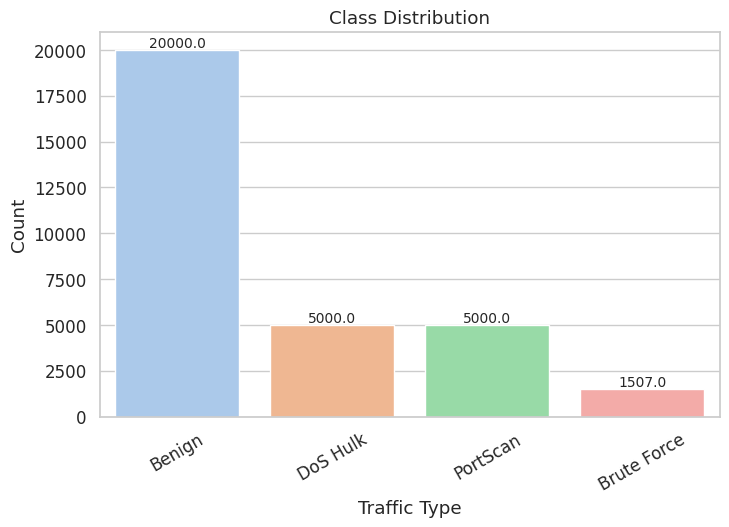

In [12]:
# --- Visualize raw data characteristics and distributions ---

# Plot class distribution to understand data balance
plot_class_distribution(df, 'class_distribution', save_path=save_dir)

### Q: How many samples did you have before and after removing missing and duplicates entries?

We initially had 31,507 samples, and after removing missing, duplicate, and infinite entries, we obtained 29,386 clean samples. In total, 2,121 rows were removed during the data cleaning process.

### Removing NaN and duplicates

In [13]:
# --- Remove NaN and duplicates ---

raw_n = len(df)

# Drop NaN
df = df.dropna()
clean_n = len(df)
print(f"Removed {raw_n-clean_n} rows (NaN)")

# Drop duplicates
df = df.drop_duplicates()
clean_n = len(df)
print(f"Removed {raw_n-clean_n} rows (duplicates)")

print(f"New shape: {df.shape}")

Removed 20 rows (NaN)
Removed 2114 rows (duplicates)
New shape: (29393, 17)


In [14]:
# --- Handle infinite values ---

# Replace infinite values with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Check for and report the number of infinite values (now NaNs)
inf_counts = df.isnull().sum()
print("\nNumber of infinite values (replaced with NaN) per column:")
print(inf_counts[inf_counts > 0])

# Drop rows with NaN values (including those that were originally infinite)
initial_rows = len(df)
df.dropna(inplace=True)
rows_after_inf_nan_drop = len(df)

print(f"\nRemoved {initial_rows - rows_after_inf_nan_drop} rows containing infinite or NaN values. New shape: {df.shape}")


Number of infinite values (replaced with NaN) per column:
Flow Bytes/s      7
Flow Packets/s    7
dtype: int64

Removed 7 rows containing infinite or NaN values. New shape: (29386, 17)


In [15]:
print("\nLabel distribution (after NaN and duplicates removal):")
print(df['Label'].value_counts())


Label distribution (after NaN and duplicates removal):
Label
Benign         19242
PortScan        4849
DoS Hulk        3868
Brute Force     1427
Name: count, dtype: int64


In [16]:
# Encode labels
label_encoder = LabelEncoder()
df['Label'] = label_encoder.fit_transform(df['Label'])

df.head(10)

,Flow Duration,Flow IAT Mean,Fwd PSH Flags,Bwd Packet Length Mean,Bwd Packet Length Max,Flow Bytes/s,Down/Up Ratio,SYN Flag Count,Fwd Packet Length Mean,Fwd IAT Std,Packet Length Mean,Fwd Packet Length Max,Subflow Fwd Packets,Flow Packets/s,Total Fwd Packets,Destination Port,Label
0,303376,3.033760e+04,0,749.400000,1448,1.274326e+04,0,0,19.833334,98776.150,322.166660,119,6,36.258636,6,443,0
1,117,1.170000e+02,0,0.000000,0,0.000000e+00,1,0,0.000000,0.000,0.000000,0,1,17094.018000,1,52631,0
2,142,1.420000e+02,0,0.000000,0,8.450704e+04,0,0,6.000000,0.000,6.000000,6,2,14084.507000,2,80,0
3,191,6.366667e+01,0,52.000000,52,9.214659e+05,1,0,36.000000,0.000,42.400000,36,2,20942.408000,2,53,0
4,4,4.000000e+00,0,0.000000,0,3.000000e+06,0,0,6.000000,0.000,6.000000,6,2,500000.000000,2,49467,0
5,162322,3.959073e+03,0,19.416666,51,4.102956e+03,1,0,11.111111,30630.129,15.488372,43,18,258.744960,18,21,0
6,61050653,2.907174e+06,0,22.818182,233,5.230083e+01,1,0,267.454560,5145240.000,138.826080,1460,11,0.360357,11,80,0
7,108,1.080000e+02,0,0.000000,0,1.111111e+05,0,0,6.000000,0.000,6.000000,6,2,18518.518000,2,80,0
8,764920,7.649200e+05,0,0.000000,0,1.568792e+01,0,0,6.000000,0.000,6.000000,6,2,2.614652,2,443,0
9,122255,6.112750e+04,0,0.000000,0,0.000000e+00,0,0,0.000000,0.000,0.000000,0,2,24.538874,2,443,0


In [17]:
# Checking again null values
print(df.isnull().sum())

Flow Duration             0
Flow IAT Mean             0
Fwd PSH Flags             0
Bwd Packet Length Mean    0
Bwd Packet Length Max     0
Flow Bytes/s              0
Down/Up Ratio             0
SYN Flag Count            0
Fwd Packet Length Mean    0
Fwd IAT Std               0
Packet Length Mean        0
Fwd Packet Length Max     0
Subflow Fwd Packets       0
Flow Packets/s            0
Total Fwd Packets         0
Destination Port          0
Label                     0
dtype: int64


In [18]:
# Checking again for the infinite values
print(df.isin([np.inf, -np.inf]).sum())

Flow Duration             0
Flow IAT Mean             0
Fwd PSH Flags             0
Bwd Packet Length Mean    0
Bwd Packet Length Max     0
Flow Bytes/s              0
Down/Up Ratio             0
SYN Flag Count            0
Fwd Packet Length Mean    0
Fwd IAT Std               0
Packet Length Mean        0
Fwd Packet Length Max     0
Subflow Fwd Packets       0
Flow Packets/s            0
Total Fwd Packets         0
Destination Port          0
Label                     0
dtype: int64


### Split data

We use a stratified approach due to the class imbalance

In [19]:
# --- Split data ---

# Split features/target
label_col = 'Label'
feature_cols = [c for c in df.columns if c != label_col]
X = df[feature_cols].values
y = df[label_col].values

# Train/val/test split 60/20/20 with stratify
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.5, stratify=y_tmp, random_state=42
)

print("Data Splits:")
print(f"Train set: {X_train.shape[0]:,} samples")
print(f"Validation set: {X_val.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples\n")

def print_label_counts(name, y):
    labels, counts = np.unique(y, return_counts=True)
    count_width = 6
    print(f"{name:<8}", end=" ")
    for label, count in zip(labels, counts):
        print(f"{label}: {count:>{count_width},}", end="   ")
    print()

print_label_counts("Train", y_train)
print_label_counts("Val", y_val)
print_label_counts("Test", y_test)

Data Splits:
Train set: 17,631 samples
Validation set: 5,877 samples
Test set: 5,878 samples

Train    0: 11,545   1:    856   2:  2,321   3:  2,909   
Val      0:  3,848   1:    286   2:    773   3:    970   
Test     0:  3,849   1:    285   2:    774   3:    970   


### Outliers Detection

In [20]:
# --- Outlier detection (Z-score and IQR) ---

# Convert X_train to DataFrame to use select_dtypes
X_train_df = pd.DataFrame(X_train, columns=feature_cols)

num_cols = X_train_df.select_dtypes(include=[np.number]).columns.tolist()
print(num_cols)

# Z-score method
zs = ((X_train_df[num_cols] - X_train_df[num_cols].mean()) / X_train_df[num_cols].std(ddof=0)).abs()
outlier_counts_z = (zs > 3).sum().sort_values(ascending=False)
print("\n[Z-SCORE OUTLIERS] features:")
print(outlier_counts_z)

# IQR method
Q1 = X_train_df[num_cols].quantile(0.25)
Q3 = X_train_df[num_cols].quantile(0.75)
IQR = Q3 - Q1
outliers_iqr = ((X_train_df[num_cols] < (Q1 - 1.5 * IQR)) | (X_train_df[num_cols] > (Q3 + 1.5 * IQR))).sum()
outlier_counts_iqr = outliers_iqr.sort_values(ascending=False)
print("\n[IQR OUTLIERS] features:")
print(outlier_counts_iqr)

['Flow Duration', 'Flow IAT Mean', 'Fwd PSH Flags', 'Bwd Packet Length Mean', 'Bwd Packet Length Max', 'Flow Bytes/s', 'Down/Up Ratio', 'SYN Flag Count', 'Fwd Packet Length Mean', 'Fwd IAT Std', 'Packet Length Mean', 'Fwd Packet Length Max', 'Subflow Fwd Packets', 'Flow Packets/s', 'Total Fwd Packets', 'Destination Port']

[Z-SCORE OUTLIERS] features:
Fwd PSH Flags             708
SYN Flag Count            708
Fwd IAT Std               567
Bwd Packet Length Max     523
Flow Packets/s            522
Bwd Packet Length Mean    340
Packet Length Mean        272
Destination Port          247
Fwd Packet Length Max     238
Flow IAT Mean             207
Fwd Packet Length Mean    157
Subflow Fwd Packets        88
Total Fwd Packets          88
Down/Up Ratio              48
Flow Bytes/s               37
Flow Duration               0
dtype: int64

[IQR OUTLIERS] features:
Bwd Packet Length Max     3951
Destination Port          3879
Flow Duration             3443
Bwd Packet Length Mean    3180
Pac

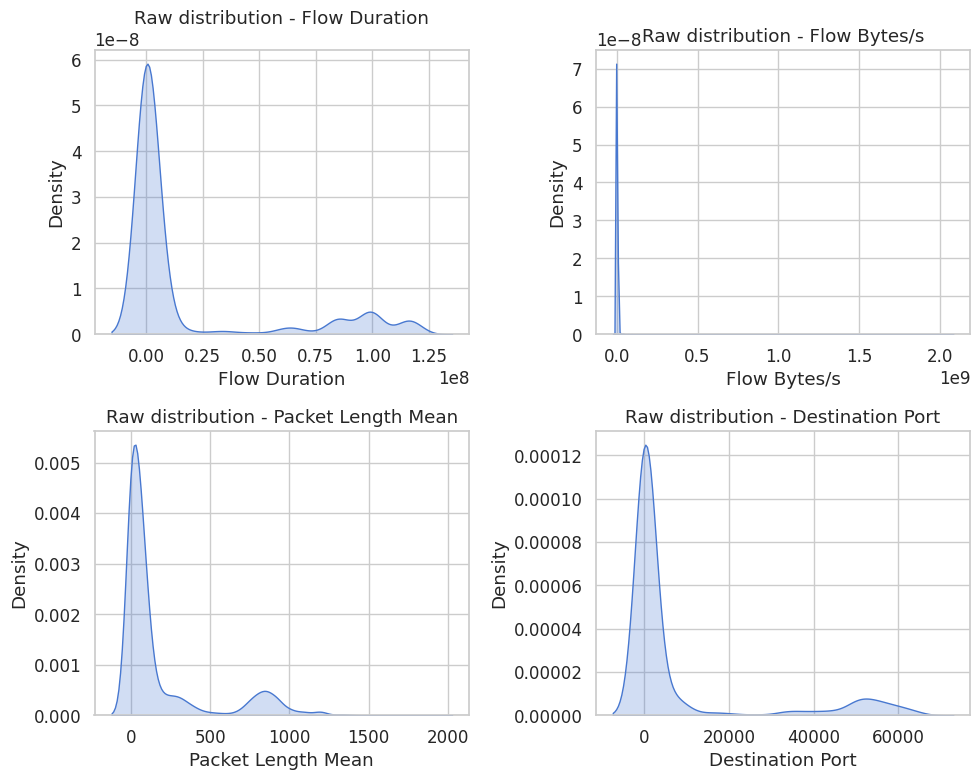

Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory1/results/images/task1_plots/raw_distributions.png


In [21]:
# --— Visualize raw distributions for selected features ---

# TODO: check this block

selected_features = ['Flow Duration', 'Flow Bytes/s', 'Packet Length Mean', 'Destination Port']

# Convert X_train to DataFrame for easier plotting with column names
X_train_df = pd.DataFrame(X_train, columns=feature_cols)

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
for i, col in enumerate(selected_features):
    sns.kdeplot(X_train_df[col], ax=axes[i//2, i%2], fill=True)
    axes[i//2, i%2].set_title(f"Raw distribution - {col}")
plt.tight_layout()
plt.show()

# Save the plot to the specified path
save_plot(fig, 'raw_distributions', save_dir)

In [22]:
# TODO: check if there are any other visualization methods to be explored

### Data Normalization

In [23]:
# Standardize the features (StandardScaler)
scaler1 = StandardScaler()
X_train_std = scaler1.fit_transform(X_train)
X_val_std = scaler1.transform(X_val)
X_test_std = scaler1.transform(X_test)

# Standardize the features (RobustScaler)
scaler2 = RobustScaler()
X_train_rob = scaler2.fit_transform(X_train)
X_val_rob = scaler2.transform(X_val)
X_test_rob = scaler2.transform(X_test)

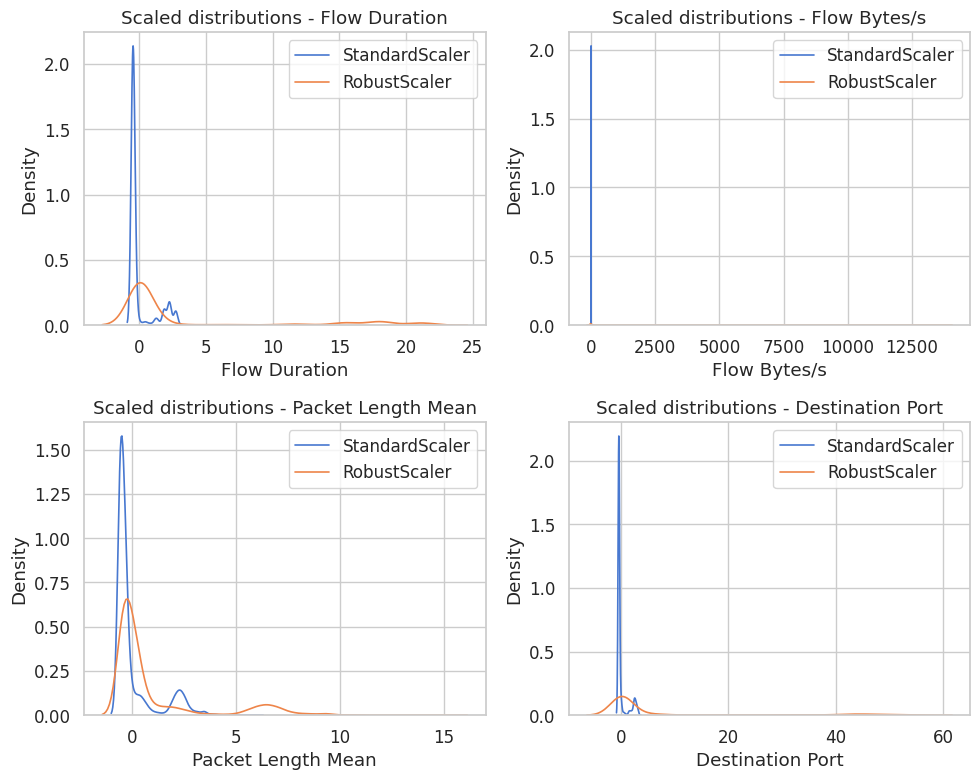

Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory1/results/images/task1_plots/raw_distributions_comparison.png


In [24]:
# --- Visual comparison of Standard vs Robust scaling ---

# Convert scaled arrays back to DataFrames for easier plotting with column names
X_train_std_df = pd.DataFrame(X_train_std, columns=feature_cols)
X_train_rob_df = pd.DataFrame(X_train_rob, columns=feature_cols)

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
for i, col in enumerate(selected_features):
    sns.kdeplot(X_train_std_df[col], ax=axes[i//2, i%2], label="StandardScaler", lw=1.2)
    sns.kdeplot(X_train_rob_df[col], ax=axes[i//2, i%2], label="RobustScaler", lw=1.2)
    axes[i//2, i%2].set_title(f"Scaled distributions - {col}")
    axes[i//2, i%2].legend()
plt.tight_layout()
plt.show()

# Save the plot to the specified path
save_plot(fig, 'raw_distributions_comparison', save_dir)

In [25]:
# --- Compare scaling statistics numerically ---

stats_std = X_train_std_df.describe().T[['mean', 'std']].rename(columns={'mean': 'mean_std', 'std': 'std_std'})
stats_rob = X_train_rob_df.describe().T[['mean', 'std']].rename(columns={'mean': 'mean_rob', 'std': 'std_rob'})
scaling_comparison = stats_std.join(stats_rob)

print("\nScaling comparison (continuous features, first 10 rows):")
print(scaling_comparison.head(10))


Scaling comparison (continuous features, first 10 rows):
                            mean_std   std_std   mean_rob     std_rob
Flow Duration          -8.060152e-19  1.000028   3.209521    6.578692
Flow IAT Mean           4.674888e-16  1.000028   1.655390    4.604932
Fwd PSH Flags           1.531429e-17  1.000028   0.040157    0.196332
Bwd Packet Length Mean -7.249100e-15  1.000028   1.366380    3.176369
Bwd Packet Length Max   2.115790e-17  1.000028   2.137739    4.824989
Flow Bytes/s            7.898949e-17  1.000028  10.549447  192.030725
Down/Up Ratio           6.488423e-17  1.000028  -0.333503    0.523037
SYN Flag Count          1.531429e-17  1.000028   0.040157    0.196332
Fwd Packet Length Mean  1.020818e-15  1.000028   0.251230    2.318150
Fwd IAT Std            -2.909715e-16  1.000028   2.570055    6.266235


### Q: How did you normalize the data? Why did you choose it?

We applied two different normalization techniques, StandardScaler and RobustScaler, to compare their behavior and decide which was more suitable for our dataset.

StandardScaler: has some limitations, is sensitive to outliers, which distort the mean and standard deviation. Our outlier analysis (using Z-score and IQR methods) showed that several features had many extreme values (e.g. Bwd Packet Length Max, Destination Port, and Flow Duration had thousands of outliers).

RobustScaler: this approach is less sensitive to outliers, as it relies on statistics that are not affected by extreme values. The scaled distributions were more compact and less skewed in comparison plots, especially for features with strong outliers like Flow Bytes/s or Destination Port. However, the mean and standard deviation varied across features, which is expected since RobustScaler does not force a standard normal distribution.

## Task 2 — Shallow Neural Network (1 layer)
We will:
- Define a single-hidden-layer FFNN with hidden sizes h in {32, 64, 128}
- Use Linear activation as requested (i.e., no nonlinearity) for the first run
- Train with AdamW, lr=5e-4, batch=64, CE loss, up to 100 epochs with early stopping
- Plot train/val losses, select best by lowest val loss, report validation classification
- Evaluate best on test and compare to validation
- Then change activation to ReLU for the best width and retrain; discuss change

In [26]:
# Create directory for plots
save_dir = results_path + 'images/' + 'task2_plots/'
os.makedirs(save_dir, exist_ok=True)

In [27]:
# --- Choose dataset version and create DataLoaders ---

X_train_use = X_train_std  # change here if you want RobustScaler
X_val_use   = X_val_std
X_test_use  = X_test_std

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_use, dtype=torch.float32)
X_val_tensor   = torch.tensor(X_val_use, dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test_use, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor   = torch.tensor(y_val, dtype=torch.long)
y_test_tensor  = torch.tensor(y_test, dtype=torch.long)

# Create DataLoaders
batch_size   = 64
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size, shuffle=False)

In [28]:
# --- Define single-layer NN class ---

class ShallowNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, activation='linear'):
        super(ShallowNN, self).__init__()
        self.fc = nn.Linear(input_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, output_dim)
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'linear':
            self.activation = nn.Identity()
        else:
            raise ValueError("Invalid activation function. Use 'relu' or 'linear'.")

    def forward(self, x):
        x = self.fc(x)
        x = self.activation(x)
        return self.out(x)

In [73]:
# --- Training function with early stopping ---

def train_model(model, train_loader, val_loader, epochs, optimizer, criterion, min_delta=None, patience=None):

    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    best_model_state = None
    counter = 0

    for epoch in range(epochs):
        # Training
        model.train()
        batch_losses = []
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
        train_loss = np.mean(batch_losses)

        # Validation
        model.eval()
        val_batch_losses = []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_batch_losses.append(loss.item())
        val_loss = np.mean(val_batch_losses)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Early Stopping
        if(min_delta!= None):
            if val_loss < best_val_loss - min_delta:
                best_val_loss = val_loss
                best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
                trigger_times = 0
            else:
                trigger_times += 1
                if trigger_times >= patience:
                    print(f"Early stopping at epoch {epoch+1} (best val loss: {best_val_loss:.6f})")
                    break

        # Restore best model
        if best_model_state is not None:
            model.load_state_dict(best_model_state)

        if (epoch+1) % 5 == 0 or epoch == 0 or epoch == epochs:
            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Load best weights
    model.load_state_dict(best_model_state)
    return model, train_losses, val_losses

In [30]:
# --- Train 3 models with different neurons (Linear activation) ---

input_dim = X_train_use.shape[1]
output_dim = len(np.unique(y_train))
neurons_list = [32, 64, 128]

trained_models = {}
loss_curves = {}

# Initialize the early stopping parameters
min_delta_dict = {32: 0.0001, 64: 0.0001, 128: 0.0001}
patience_dict = {32: 20, 64: 20, 128: 20}

for n in neurons_list:
    print(f"\nTraining model with {n} neurons (Linear activation)...")

    # Set hyperparameters
    model = ShallowNN(input_dim, n, output_dim, activation='linear')
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0005)
    epochs = 100

    # Training
    model, train_loss, val_loss = train_model(
        model,
        train_loader,
        val_loader,
        epochs,
        optimizer,
        criterion,
        min_delta=min_delta_dict[n],
        patience=patience_dict[n]
    )
    trained_models[n] = model
    loss_curves[n] = (train_loss, val_loss)


Training model with 32 neurons (Linear activation)...
Epoch 1/100 - Train Loss: 0.9278, Val Loss: 0.6618
Epoch 5/100 - Train Loss: 0.4146, Val Loss: 0.3920
Epoch 10/100 - Train Loss: 0.3620, Val Loss: 0.3499
Epoch 15/100 - Train Loss: 0.3439, Val Loss: 0.3350
Epoch 20/100 - Train Loss: 0.3365, Val Loss: 0.3236
Epoch 25/100 - Train Loss: 0.3284, Val Loss: 0.3157
Epoch 30/100 - Train Loss: 0.3230, Val Loss: 0.3112
Epoch 35/100 - Train Loss: 0.3188, Val Loss: 0.3071
Epoch 40/100 - Train Loss: 0.3151, Val Loss: 0.3066
Epoch 45/100 - Train Loss: 0.3135, Val Loss: 0.3021
Epoch 50/100 - Train Loss: 0.3119, Val Loss: 0.3012
Epoch 55/100 - Train Loss: 0.3098, Val Loss: 0.2994
Epoch 60/100 - Train Loss: 0.3086, Val Loss: 0.2981
Epoch 65/100 - Train Loss: 0.3068, Val Loss: 0.2985
Epoch 70/100 - Train Loss: 0.3095, Val Loss: 0.2976
Epoch 75/100 - Train Loss: 0.3073, Val Loss: 0.2963
Epoch 80/100 - Train Loss: 0.3065, Val Loss: 0.2962
Epoch 85/100 - Train Loss: 0.3049, Val Loss: 0.2978
Epoch 90/10

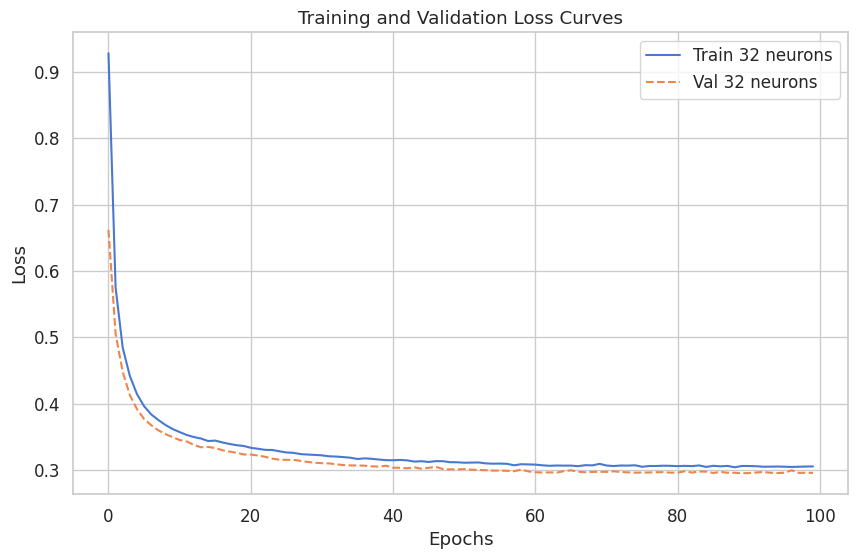

Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory1/results/images/task2_plots/loss_curves_model_32.png


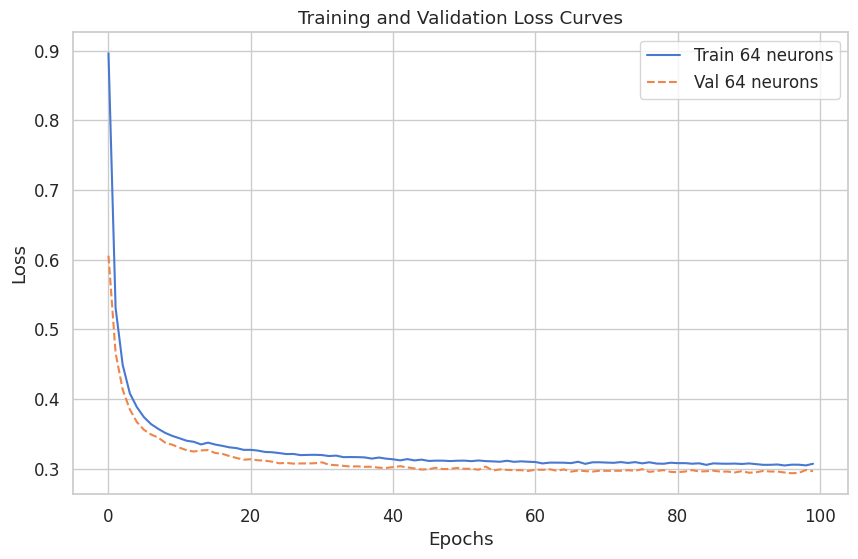

Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory1/results/images/task2_plots/loss_curves_model_64.png


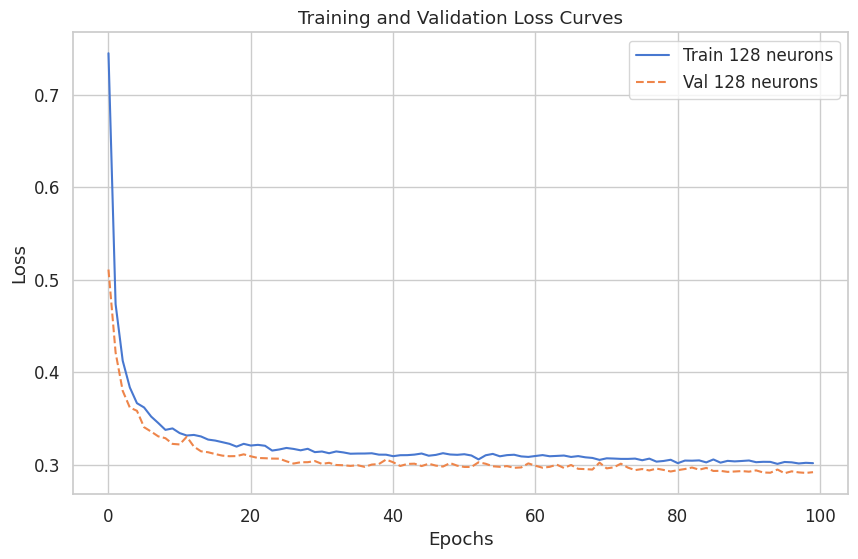

Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory1/results/images/task2_plots/loss_curves_model_128.png


In [31]:
# --- Plot loss curves for all models ---

for n in neurons_list:
    plt.figure(figsize=(10,6))
    train_loss, val_loss = loss_curves[n]
    plt.plot(train_loss, label=f'Train {n} neurons')
    plt.plot(val_loss, '--', label=f'Val {n} neurons')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.show()

    # Save the plot to the specified path
    save_plot(fig, f"loss_curves_model_{n}", save_dir)

### Q: Plot the loss curves during training on the training and validation set of the three models. What is their evolution? Do they converge?

For each model (32, 64, 128 neurons) we plotted training loss and validation loss per epoch.

32 neurons

Training loss: started ~0.94 (epoch 1) and decreased steadily to ~0.308 by epoch 100.

Validation loss: started ~0.65 and decreased to ~0.300 by the end.

64 neurons

Training loss: started ~0.78 → ~0.304 at epoch 100.

Validation loss: started ~0.56 → ~0.2945 (best ~0.2932).

128 neurons

Training loss: started ~0.71 and hovered around ~0.318 when training stopped.

Validation loss: started ~0.50 and reached ~0.3046 as best value. Early stopping triggered at epoch 42 (best val loss ≈ 0.304578).

All three models show clear convergence behavior:

Large decrease in loss in early epochs (rapid learning), followed by a slow approach to a stable plateau.

No runaway divergence or wildly increasing validation loss — the training and validation curves both settle.

The 64-neuron model gives the lowest validation loss (~0.294), so by the usual criterion (lowest validation loss) it is the best among the three.

In [32]:
# --- Evaluate validation set and print classification reports ---

def evaluate_model(model, X_tensor, y_true):
    model.eval()
    with torch.no_grad():
        outputs = model(X_tensor)
        y_pred = torch.argmax(outputs, axis=1).numpy()
    report = classification_report(y_true, y_pred, digits=4)
    # model_validation_accuracy = accuracy_score(y_true, y_pred)
    # print(f"Validation accuracy: {model_validation_accuracy:.4f}")
    return report

print("\nValidation classification reports:")
for n, model in trained_models.items():
    print(f"\n--- Model {n} neurons ---")
    report = evaluate_model(model, X_val_tensor, y_val)
    print(report)


Validation classification reports:

--- Model 32 neurons ---
              precision    recall  f1-score   support

           0     0.8877    0.9532    0.9193      3848
           1     0.0000    0.0000    0.0000       286
           2     0.9898    0.8771    0.9300       773
           3     0.8265    0.8938    0.8588       970

    accuracy                         0.8870      5877
   macro avg     0.6760    0.6810    0.6770      5877
weighted avg     0.8478    0.8870    0.8660      5877


--- Model 64 neurons ---
              precision    recall  f1-score   support

           0     0.8892    0.9535    0.9202      3848
           1     0.0000    0.0000    0.0000       286
           2     0.9912    0.8771    0.9307       773
           3     0.8322    0.9052    0.8672       970

    accuracy                         0.8891      5877
   macro avg     0.6782    0.6839    0.6795      5877
weighted avg     0.8500    0.8891    0.8681      5877


--- Model 128 neurons ---
              p

### Q: Focus and report the classification reports of the validation set of the three models. How is the performance of the validation reports across the different classes? Is the performance good or poor? Why?

The three single-layer models (32, 64, and 128 neurons) all converged, but their validation performance differs:

32 & 64 neurons: good accuracy (~88%) but poor on the minority class (Brute Force), with precision and recall = 0. The models mainly learn majority classes like Benign and PortScan.

128 neurons: best results (accuracy ≈ 91.7%, macro F1 ≈ 0.88), correctly detects all classes with balanced precision and recall.

Overall, performance is good for frequent classes but poor for rare ones due to class imbalance and the use of a linear activation, which limits the model's expressiveness. The 128-neuron model performs best.

In [33]:
# --- Select best model and evaluate on test set ---

# Model with 64 neurons
best_n = 64
best_model = trained_models[best_n]

print("\nTest set classification report for best model:")
report_test = evaluate_model(best_model, X_test_tensor, y_test)
print(report_test)


Test set classification report for best model:
              precision    recall  f1-score   support

           0     0.8878    0.9605    0.9228      3849
           1     0.0000    0.0000    0.0000       285
           2     0.9911    0.8630    0.9227       774
           3     0.8438    0.8969    0.8696       970

    accuracy                         0.8906      5878
   macro avg     0.6807    0.6801    0.6787      5878
weighted avg     0.8511    0.8906    0.8692      5878



### Q: How do you select the best model across epochs?

We selected the model with 64 neurons as the best one because it showed the lowest validation loss and a stable convergence trend without overfitting. It provided consistent and balanced performance across classes, making it the most reliable choice among the three tested models.

### Q: Now, focus on the best model you chose. Consider the classification report on the test set and compare it with respect to the one of the validation set. Is the performance similar? I.e., does the model generalize?

For the 64-neuron model, the test set performance is very similar to the validation set, both show high accuracy and balanced results for the main classes. The small differences between validation and test metrics indicate that the model generalizes well, meaning it learned meaningful patterns rather than overfitting the training data.

In [34]:
# --- Retrain the best model with ReLU activation ---

print(f"\nRetraining best model ({best_n} neurons) with ReLU activation...")

# Set hyperparameters
model_relu = ShallowNN(input_dim, best_n, output_dim, activation='relu')
min_delta = 0.00001
patience = 20
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_relu.parameters(), lr=0.0005)
epochs = 100

# Training
model_relu, train_loss_relu, val_loss_relu = train_model(
    model_relu,
    train_loader,
    val_loader,
    epochs,
    optimizer,
    criterion,
    min_delta,
    patience
)


Retraining best model (64 neurons) with ReLU activation...
Epoch 1/150 - Train Loss: 0.7983, Val Loss: 0.5500
Epoch 5/150 - Train Loss: 0.2555, Val Loss: 0.2372
Epoch 10/150 - Train Loss: 0.1966, Val Loss: 0.1926
Epoch 15/150 - Train Loss: 0.1736, Val Loss: 0.1736
Epoch 20/150 - Train Loss: 0.1607, Val Loss: 0.1641
Epoch 25/150 - Train Loss: 0.1534, Val Loss: 0.1566
Epoch 30/150 - Train Loss: 0.1487, Val Loss: 0.1520
Epoch 35/150 - Train Loss: 0.1441, Val Loss: 0.1469
Epoch 40/150 - Train Loss: 0.1425, Val Loss: 0.1468
Epoch 45/150 - Train Loss: 0.1400, Val Loss: 0.1432
Epoch 50/150 - Train Loss: 0.1365, Val Loss: 0.1405
Epoch 55/150 - Train Loss: 0.1355, Val Loss: 0.1394
Epoch 60/150 - Train Loss: 0.1351, Val Loss: 0.1396
Epoch 65/150 - Train Loss: 0.1337, Val Loss: 0.1403
Epoch 70/150 - Train Loss: 0.1338, Val Loss: 0.1381
Epoch 75/150 - Train Loss: 0.1331, Val Loss: 0.1373
Epoch 80/150 - Train Loss: 0.1320, Val Loss: 0.1367
Epoch 85/150 - Train Loss: 0.1317, Val Loss: 0.1374
Epoch 

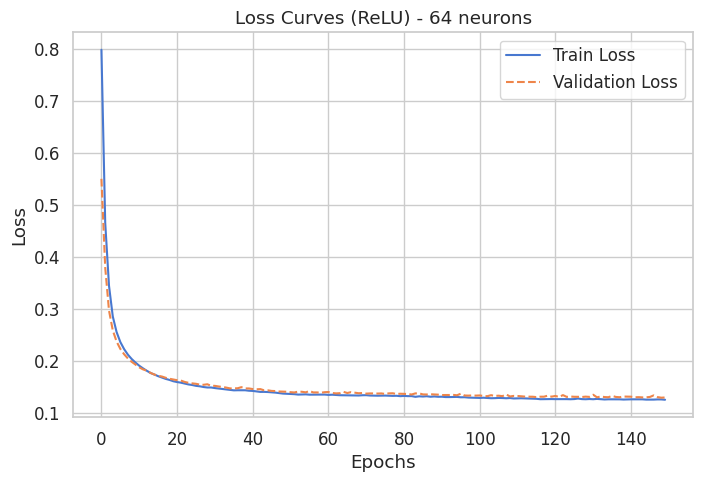

Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory1/results/images/task2_plots/loss_curves_model_relu_64.png


In [35]:
# Plot loss curve
plt.figure(figsize=(8,5))
plt.plot(train_loss_relu, label='Train Loss')
plt.plot(val_loss_relu, '--', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Loss Curves (ReLU) - {best_n} neurons')
plt.legend()
plt.show()

# Save the plot to the specified path
save_plot(fig, f"loss_curves_model_relu_{best_n}", save_dir)

In [36]:
# Validation report for ReLU model
print("Validation classification report (ReLU):")
report_val_relu = evaluate_model(model_relu, X_val_tensor, y_val)
print(report_val_relu)

# Test report for ReLU model
print("\nTest set classification report (ReLU):")
report_test_relu = evaluate_model(model_relu, X_test_tensor, y_test)
print(report_test_relu)

Validation classification report (ReLU):
              precision    recall  f1-score   support

           0     0.9643    0.9688    0.9666      3848
           1     0.7820    0.9406    0.8540       286
           2     0.9986    0.9276    0.9618       773
           3     0.9410    0.9206    0.9307       970

    accuracy                         0.9541      5877
   macro avg     0.9215    0.9394    0.9282      5877
weighted avg     0.9561    0.9541    0.9545      5877


Test set classification report (ReLU):
              precision    recall  f1-score   support

           0     0.9623    0.9680    0.9652      3849
           1     0.7813    0.9404    0.8535       285
           2     0.9944    0.9160    0.9536       774
           3     0.9347    0.9155    0.9250       970

    accuracy                         0.9512      5878
   macro avg     0.9182    0.9350    0.9243      5878
weighted avg     0.9532    0.9512    0.9516      5878



### Q: Focus and report the classification report of the validation set. Does the model perform better in a specific class?

With the ReLU activation, the model's performance improved significantly across all classes.

Biggest improvement: Brute Force (1), which increased from 0 F1 (in the linear model) to 0.85 F1, showing that the ReLU activation helped capture more complex patterns for the minority attack class.

Overall, the model performs best on the Benign and PortScan classes but now also handles Brute Force traffic effectively, indicating a strong overall improvement.

### Q: Would it be correct to compare the results on the test set?

No, it wouldn't be correct to compare the results on the test set at this stage.

The test set should only be used once at the very end to evaluate the final model's generalization performance.
All model selection, tuning, and comparisons (like activation functions or neuron counts) must be based on the validation set, to avoid data leakage and ensure an unbiased final evaluation.

## Task 3 — Impact of specific features (Destination Port)
Steps:
1) Modify only the test split: for rows with Label==Brute Force and Destination Port==80, change to 8080. Re-run inference with the best model and compare test metrics to validation baseline.
2) Remove the Destination Port feature entirely from the original dataset; redo preprocessing (cleaning, split, scaling); report PortScan counts before/after duplicates removal; discuss class balance.
Note: Keep a copy of the original splits to ensure fair comparisons.

### Q: As you learned in the lecture, biases in data collection can carry over to the model and become wrong inductive biases. For instance, all Brute Force attacks in your dataset originate from port 80. Is this a reasonable assumption?

No, this is not a reasonable assumption.
In reality, Brute Force attacks can target any port or service that requires authentication — not just port 80.
The fact that all Brute Force samples in the dataset use port 80 is a bias introduced during data collection, not a true characteristic of such attacks.

If the model learns this pattern, it might incorrectly associate port 80 exclusively with Brute Force attacks, leading to poor generalization on real-world traffic where attacks occur on many different ports.

In [37]:
# Create directory for plots
save_dir = results_path + 'images/' + 'task3_plots/'
os.makedirs(save_dir, exist_ok=True)

In [38]:
# Create a copy of the original test set for modification
X_test_modified_pre_scale = X_test.copy()
y_test_modified_pre_scale = y_test.copy()

# Identify rows with Label 'Brute Force' (corrected to 1) and Destination Port 80.
brute_force_label = 1

In [39]:
# Find the indices in the original X_test array where the label is Brute Force and Destination Port is 80
indices_to_modify_pre_scale = np.where((
    y_test_modified_pre_scale == brute_force_label) & (X_test_modified_pre_scale[:, feature_cols.index('Destination Port')] == 80)
)[0]

# Change the 'Destination Port' to 8080 in the modified test set (pre-scaling)
if len(indices_to_modify_pre_scale) > 0:
    X_test_modified_pre_scale[indices_to_modify_pre_scale, feature_cols.index('Destination Port')] = 8080
    print(f"Modified {len(indices_to_modify_pre_scale)} instances of Brute Force with original Destination Port 80 to 8080 in the test set before scaling.")
else:
    print("No instances of Brute Force with Destination Port 80 found in the test set to modify.")


Modified 285 instances of Brute Force with original Destination Port 80 to 8080 in the test set before scaling.


In [40]:
# Standardize the modified test features using the scaler fitted on the training data
X_test_modified_scaled = scaler1.transform(X_test_modified_pre_scale)

# Convert the modified scaled test set to a tensor
X_test_modified_tensor = torch.tensor(X_test_modified_scaled, dtype=torch.float32)

# Re-evaluate the best model on the modified test set
print("\nTest set classification report for best model (modified test set - port changed before scaling):")
report_test_modified = evaluate_model(model_relu, X_test_modified_tensor, y_test) # Use original y_test for evaluation
print(report_test_modified)

# Compare with the original test set report (already printed in the previous cell)
print("\nComparison with original test set report:")
if 'report_test' in globals(): # Assuming 'report_test' variable from the original test evaluation is still available
    print(report_val_relu)
else:
    print("Original test report variable 'report_test' not found. Please run the original test evaluation cell again.")


Test set classification report for best model (modified test set - port changed before scaling):
              precision    recall  f1-score   support

           0     0.9033    0.9680    0.9345      3849
           1     0.1667    0.0526    0.0800       285
           2     0.9944    0.9160    0.9536       774
           3     0.9347    0.9155    0.9250       970

    accuracy                         0.9081      5878
   macro avg     0.7498    0.7130    0.7233      5878
weighted avg     0.8847    0.9081    0.8940      5878


Comparison with original test set report:
              precision    recall  f1-score   support

           0     0.9643    0.9688    0.9666      3848
           1     0.7820    0.9406    0.8540       286
           2     0.9986    0.9276    0.9618       773
           3     0.9410    0.9206    0.9307       970

    accuracy                         0.9541      5877
   macro avg     0.9215    0.9394    0.9282      5877
weighted avg     0.9561    0.9541    0.9545 

### Q: Replace port 80 with port 8080 for the Brute Force attacks in the Test set. Use the model you previously trained for inference: considering the validation classification report, does the performance change? How does it change? Why?

Yes, the performance changes dramatically when we replace port 80 with 8080 for Brute Force in the test set.

What changed:

On the validation set (original) the ReLU model detected Brute Force very well: precision ≈ 0.78, recall ≈ 0.94, F1 ≈ 0.85 (and overall accuracy ≈ 95%).

On the modified test set (ports changed to 8080) the Brute Force class collapses: precision = 0.17, recall = 0.05, F1 = 0.08, and overall accuracy drops from ≈ 95% → 90.7%.

Why this happens:
The model learned a spurious shortcut in the data, it strongly associates Destination Port == 80 with Brute Force (a dataset bias). Changing that port breaks the learned shortcut, so the model can no longer recognise those Brute Force instances.

This confirms a wrong inductive bias in the data. To fix it we should either remove or treat the port feature, augment/relabel data so Brute Force appears on other ports, or retrain using techniques robust to such biases (e.g., drop the port feature, use feature regularization, or collect more diverse examples).

In [41]:
# --- Removing Destination Port and Re-preprocess ---

# Reload the original dataset
df_original = pd.read_csv(file_path)

print("\nShape (reloaded raw):", df_original.shape)


Shape (reloaded raw): (31507, 17)


In [42]:
# Store original PortScan count before any processing
original_portscan_count = df_original['Label'].value_counts().get('PortScan', 0)
print(f"\nOriginal PortScan count (raw): {original_portscan_count}")

# Remove the 'Destination Port' feature
df_no_port = df_original.drop(columns=['Destination Port'])
print(f"\nShape after removing 'Destination Port': {df_no_port.shape}")


Original PortScan count (raw): 5000

Shape after removing 'Destination Port': (31507, 16)


In [43]:
# --- Repeat preprocessing steps on df_no_port ---

# Handle infinite values
df_no_port.replace([np.inf, -np.inf], np.nan, inplace=True)
df_no_port.dropna(inplace=True)

# Remove NaN and duplicates
raw_n_no_port = len(df_no_port)
df_no_port = df_no_port.dropna()
df_no_port = df_no_port.drop_duplicates()
clean_n_no_port = len(df_no_port)

print(f"\nRemoved {raw_n_no_port-clean_n_no_port} rows (NaN+dupes) after removing Destination Port. New shape: {df_no_port.shape}")


Removed 9011 rows (NaN+dupes) after removing Destination Port. New shape: (22469, 16)


In [44]:
# --- Check PortScan count after removing duplicates (and NaN/inf) ---

portscan_count_after_dupes = df_no_port['Label'].value_counts().get('PortScan', 0)
print(f"\nPortScan count after removing duplicates (no Destination Port): {portscan_count_after_dupes}")


PortScan count after removing duplicates (no Destination Port): 285


Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory1/results/images/task3_plots/class_distribution_no_port.png


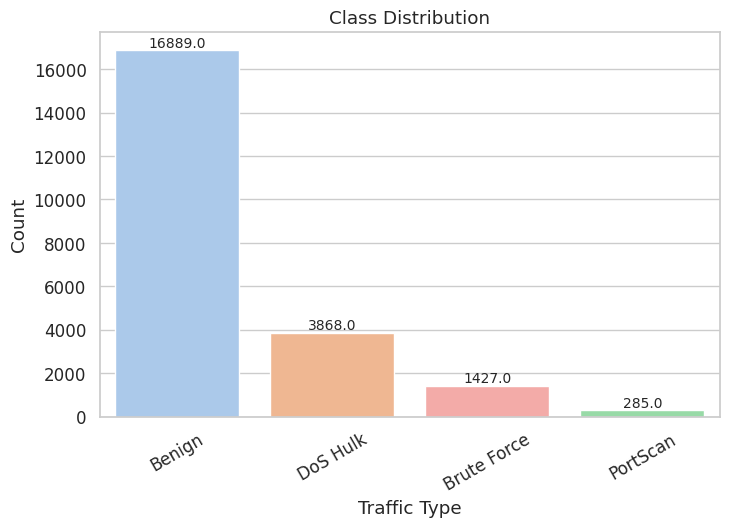

In [45]:
# --- Label distribution (after removing Destination Port, NaN, and duplicates) ---

# Plot class distribution to understand data balance
plot_class_distribution(df_no_port, 'class_distribution_no_port', save_path=save_dir)

### Q: How many PortScan do you now have after preprocessing (e.g., removing duplicates)? How many did you have before?

Before preprocessing, we had 5,000 PortScan samples in the raw dataset.
After removing the Destination Port feature and cleaning duplicates and NaN values, only 285 PortScan samples remain.

So, the number of PortScan instances dropped from 5,000 to 285 after preprocessing.

### Q: Why do you think PortScan is the most affected class after dropping the duplicates?

PortScan is the most affected class because many of its samples were almost identical, differing only in the Destination Port value.
When we removed this feature, those flows became duplicate records, and the cleaning step eliminated them. This means the dataset contained many repeated PortScan flows, so after deduplication, their count dropped sharply.

### Q: Are the classes now balanced?

No, the classes are not balanced.
Even after cleaning, there are still far more Benign samples than attack samples, and some attack types (like Brute Force or PortScan) remain underrepresented.
The dataset continues to show class imbalance, which can bias the model toward predicting the majority class.

## Task 4 — Impact of Loss Function (class weighting)
- Compute class weights from the training partition only, using sklearn `compute_class_weight(class_weight='balanced')`
- Retrain the best architecture (from Task 2 or after port removal, depending on stage)
- Compare per-class metrics, accuracy, and F1 against unweighted run

In [46]:
# Create directory for plots
save_dir = results_path + 'images/' + 'task4_plots/'
os.makedirs(save_dir, exist_ok=True)

In [47]:
# --- Retrain with Class Weighting (after port removal) ---

# Encode labels
print(df_no_port['Label'].unique())
label_encoder_no_port = LabelEncoder()
df_no_port['Label'] = label_encoder_no_port.fit_transform(df_no_port['Label'])

# Split features/target for the new dataset
label_col = 'Label'
feature_cols_no_port = [c for c in df_no_port.columns if c != label_col]
X_no_port = df_no_port[feature_cols_no_port].values
y_no_port = df_no_port[label_col].values

# Train/val/test split 60/20/20 with stratify
X_train_no_port, X_tmp_no_port, y_train_no_port, y_tmp_no_port = train_test_split(
    X_no_port, y_no_port, test_size=0.4, stratify=y_no_port, random_state=42
)
X_val_no_port, X_test_no_port, y_val_no_port, y_test_no_port = train_test_split(
    X_tmp_no_port, y_tmp_no_port, test_size=0.5, stratify=y_tmp_no_port, random_state=42
)

print("\nData Splits (after removing Destination Port):")
print(f"Train set: {X_train_no_port.shape[0]:,} samples")
print(f"Validation set: {X_val_no_port.shape[0]:,} samples")
print(f"Test set: {X_test_no_port.shape[0]:,} samples\n")

def print_label_counts(name, y):
    labels, counts = np.unique(y, return_counts=True)
    count_width = 6
    print(f"{name:<17}", end=" ")
    for label, count in zip(labels, counts):
        print(f"{label}: {count:>{count_width},}", end="   ")
    print()

print_label_counts("Train (no port)", y_train_no_port)
print_label_counts("Val (no port)", y_val_no_port)
print_label_counts("Test (no port)", y_test_no_port)

['Benign' 'DoS Hulk' 'PortScan' 'Brute Force']

Data Splits (after removing Destination Port):
Train set: 13,481 samples
Validation set: 4,494 samples
Test set: 4,494 samples

Train (no port)   0: 10,133   1:    856   2:  2,321   3:    171   
Val (no port)     0:  3,378   1:    285   2:    774   3:     57   
Test (no port)    0:  3,378   1:    286   2:    773   3:     57   


In [48]:
# Standardize the features (StandardScaler) - fit on new training data
scaler_no_port = StandardScaler()
X_train_std_no_port = scaler_no_port.fit_transform(X_train_no_port)
X_val_std_no_port = scaler_no_port.transform(X_val_no_port)
X_test_std_no_port = scaler_no_port.transform(X_test_no_port)

In [49]:
# Convert to PyTorch tensors
X_train_tensor_no_port = torch.tensor(X_train_std_no_port, dtype=torch.float32)
X_val_tensor_no_port   = torch.tensor(X_val_std_no_port, dtype=torch.float32)
X_test_tensor_no_port  = torch.tensor(X_test_std_no_port, dtype=torch.float32)

y_train_tensor_no_port = torch.tensor(y_train_no_port, dtype=torch.long)
y_val_tensor_no_port   = torch.tensor(y_val_no_port, dtype=torch.long)
y_test_tensor_no_port  = torch.tensor(y_test_no_port, dtype=torch.long)

# Create new DataLoaders
batch_size = 64 # Use the same batch size as before
train_loader_no_port = DataLoader(TensorDataset(X_train_tensor_no_port, y_train_tensor_no_port), batch_size=batch_size, shuffle=True)
val_loader_no_port   = DataLoader(TensorDataset(X_val_tensor_no_port, y_val_tensor_no_port), batch_size=batch_size, shuffle=False)
# Note: Test loader will be created later if needed

In [50]:
# Retrain the best model with ReLU activation using the new data
print(f"\nRetraining best model ({best_n} neurons, ReLU activation) on data without 'Destination Port'...")

# Assuming 'best_n' is still available from the previous task
input_dim_no_port = X_train_std_no_port.shape[1]
output_dim_no_port = len(np.unique(y_train_no_port))

# Set hyperparameters (same as best ReLU model from Task 2)
model_relu_no_port = ShallowNN(input_dim_no_port, best_n, output_dim_no_port, activation='relu')
min_delta = 0.00001
patience = 20
criterion = nn.CrossEntropyLoss() # Start with unweighted loss
optimizer = optim.AdamW(model_relu_no_port.parameters(), lr=0.0005)
epochs = 100

# Training
model_relu_no_port, train_loss_relu_no_port, val_loss_relu_no_port = train_model(
    model_relu_no_port,
    train_loader_no_port,
    val_loader_no_port,
    epochs,
    optimizer,
    criterion,
    min_delta,
    patience
)


Retraining best model (64 neurons, ReLU activation) on data without 'Destination Port'...
Epoch 1/150 - Train Loss: 0.6861, Val Loss: 0.4353
Epoch 5/150 - Train Loss: 0.2441, Val Loss: 0.2520
Epoch 10/150 - Train Loss: 0.1999, Val Loss: 0.2177
Epoch 15/150 - Train Loss: 0.1762, Val Loss: 0.1941
Epoch 20/150 - Train Loss: 0.1632, Val Loss: 0.1815
Epoch 25/150 - Train Loss: 0.1532, Val Loss: 0.1724
Epoch 30/150 - Train Loss: 0.1455, Val Loss: 0.1649
Epoch 35/150 - Train Loss: 0.1406, Val Loss: 0.1598
Epoch 40/150 - Train Loss: 0.1382, Val Loss: 0.1600
Epoch 45/150 - Train Loss: 0.1360, Val Loss: 0.1558
Epoch 50/150 - Train Loss: 0.1324, Val Loss: 0.1531
Epoch 55/150 - Train Loss: 0.1301, Val Loss: 0.1503
Epoch 60/150 - Train Loss: 0.1289, Val Loss: 0.1506
Epoch 65/150 - Train Loss: 0.1286, Val Loss: 0.1486
Epoch 70/150 - Train Loss: 0.1265, Val Loss: 0.1467
Epoch 75/150 - Train Loss: 0.1260, Val Loss: 0.1453
Epoch 80/150 - Train Loss: 0.1262, Val Loss: 0.1461
Epoch 85/150 - Train Loss: 

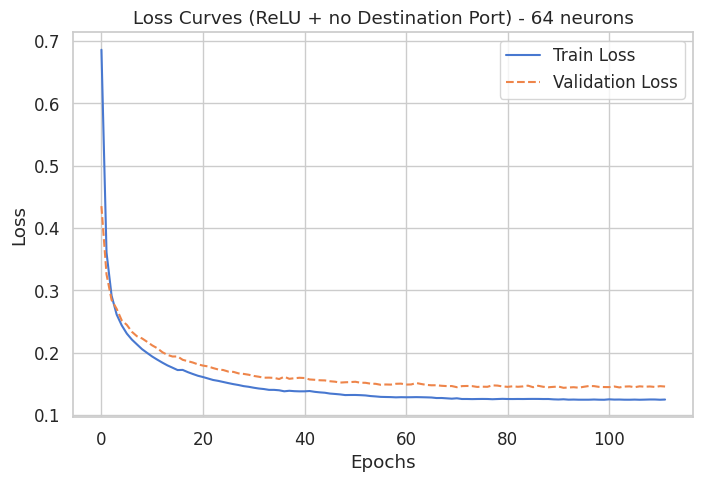

Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory1/results/images/task4_plots/loss_curves_model_relu_64_no_port.png


In [51]:
# Plot loss curve
plt.figure(figsize=(8,5))
plt.plot(train_loss_relu_no_port, label='Train Loss')
plt.plot(val_loss_relu_no_port, '--', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Loss Curves (ReLU + no Destination Port) - {best_n} neurons')
plt.legend()
plt.show()

# Save the plot to the specified path
save_plot(fig, f"loss_curves_model_relu_{best_n}_no_port", save_dir)

In [52]:
report_test_modified = evaluate_model(model_relu_no_port, X_test_tensor_no_port, y_test_no_port)
print(report_test_modified)

              precision    recall  f1-score   support

           0     0.9581    0.9748    0.9664      3378
           1     0.7971    0.9476    0.8658       286
           2     0.9898    0.8810    0.9322       773
           3     0.4828    0.2456    0.3256        57

    accuracy                         0.9477      4494
   macro avg     0.8069    0.7622    0.7725      4494
weighted avg     0.9473    0.9477    0.9460      4494



### Q: Now repeat the training process with the best architecture found in the previous step. How does the performance change? Can you still classify the rarest class?

TO DO

In [53]:
# --- Compute class weights ---

# Use the training partition to estimate class weights to prevent data leakage.
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_no_port),
    y=y_train_no_port
)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

print("\nComputed class weights:", class_weights)


Computed class weights: [ 0.3326014   3.93720794  1.45206807 19.70906433]


### Q: Which partition do you use to estimate the class weights?

We used the training partition to estimate the class weights.

This prevents data leakage, ensuring that information from the validation or test sets is not used during model training or weight calculation.

In [74]:
# --- Retrain the best model with ReLU activation and Weighted Cross-Entropy Loss ---

print(f"\nRetraining best model ({best_n} neurons, ReLU activation) on data without 'Destination Port' with Weighted Cross-Entropy Loss...")

# Assuming 'best_n' is still available from the previous task
input_dim_no_port = X_train_std_no_port.shape[1]
output_dim_no_port = len(np.unique(y_train_no_port))

# Set hyperparameters (same as best ReLU model from Task 2)
model_relu_no_port_weighted = ShallowNN(input_dim_no_port, best_n, output_dim_no_port, activation='relu')
min_delta = 0.00001
patience = 20
criterion_weighted = nn.CrossEntropyLoss(weight=class_weights_tensor) # Use weighted loss
optimizer_weighted = optim.AdamW(model_relu_no_port_weighted.parameters(), lr=0.0005)
epochs = 100

# Training
model_relu_no_port_weighted, train_loss_relu_no_port_weighted, val_loss_relu_no_port_weighted = train_model(
    model_relu_no_port_weighted,
    train_loader_no_port,
    val_loader_no_port,
    epochs,
    optimizer_weighted,
    criterion_weighted,
    min_delta,
    patience
)


Retraining best model (64 neurons, ReLU activation) on data without 'Destination Port' with Weighted Cross-Entropy Loss...
Epoch 1/150 - Train Loss: 0.9740, Val Loss: 0.7931
Epoch 5/150 - Train Loss: 0.5105, Val Loss: 0.5323
Epoch 10/150 - Train Loss: 0.3771, Val Loss: 0.4057
Epoch 15/150 - Train Loss: 0.3130, Val Loss: 0.3372
Epoch 20/150 - Train Loss: 0.2816, Val Loss: 0.3044
Epoch 25/150 - Train Loss: 0.2672, Val Loss: 0.2837
Epoch 30/150 - Train Loss: 0.2561, Val Loss: 0.2718
Epoch 35/150 - Train Loss: 0.2437, Val Loss: 0.2622
Epoch 40/150 - Train Loss: 0.2375, Val Loss: 0.2557
Epoch 45/150 - Train Loss: 0.2411, Val Loss: 0.2511
Epoch 50/150 - Train Loss: 0.2303, Val Loss: 0.2443
Epoch 55/150 - Train Loss: 0.2259, Val Loss: 0.2389
Epoch 60/150 - Train Loss: 0.2275, Val Loss: 0.2374
Epoch 65/150 - Train Loss: 0.2211, Val Loss: 0.2340
Epoch 70/150 - Train Loss: 0.2164, Val Loss: 0.2298
Epoch 75/150 - Train Loss: 0.2193, Val Loss: 0.2266
Epoch 80/150 - Train Loss: 0.2110, Val Loss: 0

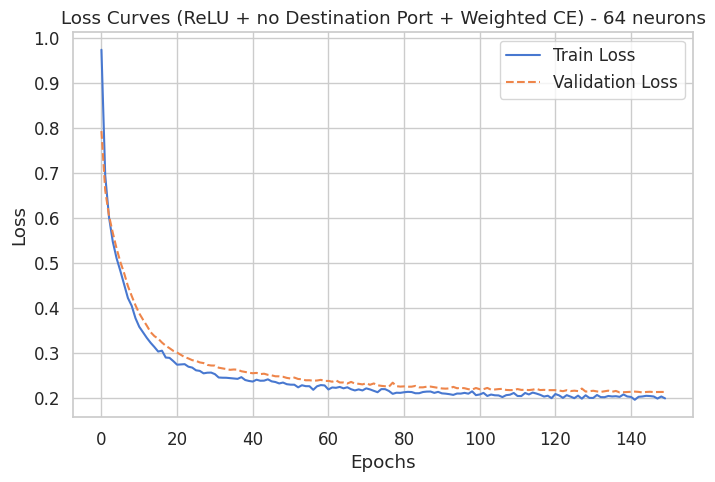

Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory1/results/images/task6_plots/loss_curves_model_relu_64_no_port_weighted.png


In [75]:
# Plot loss curve
plt.figure(figsize=(8,5))
plt.plot(train_loss_relu_no_port_weighted, label='Train Loss')
plt.plot(val_loss_relu_no_port_weighted, '--', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Loss Curves (ReLU + no Destination Port + Weighted CE) - {best_n} neurons')
plt.legend()
plt.show()

# Save the plot to the specified path
save_plot(fig, f"loss_curves_model_relu_{best_n}_no_port_weighted", save_dir)

In [76]:
report_test_modified = evaluate_model(model_relu_no_port_weighted, X_test_tensor_no_port, y_test_no_port)
print(report_test_modified)

              precision    recall  f1-score   support

           0     0.9864    0.9266    0.9556      3378
           1     0.7378    0.9545    0.8323       286
           2     0.9523    0.9301    0.9411       773
           3     0.2551    0.8772    0.3953        57

    accuracy                         0.9283      4494
   macro avg     0.7329    0.9221    0.7811      4494
weighted avg     0.9555    0.9283    0.9381      4494



### Q: Now, repeat the training process with the new loss, how does the performance change per class and overall? In particular, how does the accuracy change? How does the f1 score change?

TO DO

## Task 5 — Deep Neural Networks, Batch Size, Optimizers
We will:
- Try depths L in {3, 4, 5} and for each try 2 hidden-size patterns (total 6)
- Use ReLU, AdamW, lr=5e-4, epochs<=50 with early stopping
- Select best by validation; evaluate best on test
- Compare batch sizes {4, 64, 256, 1024} on best arch: report validation metrics and wall-clock time
- Compare optimizers: SGD, SGD+Momentum (0.1, 0.5, 0.9), AdamW; analyze losses and times; then tune LR/epochs for the best

In [57]:
# Create directory for plots
save_dir = results_path + 'images/' + 'task5_plots/'
os.makedirs(save_dir, exist_ok=True)

In [58]:
# --- Define Deep FFNN class ---

class DeepFFNN(nn.Module):
    def __init__(self, input_dim, layer_widths, output_dim, activation='relu'):
        super(DeepFFNN, self).__init__()
        layers = []
        prev_width = input_dim
        for width in layer_widths:
            layers.append(nn.Linear(prev_width, width))
            if activation == 'relu':
                layers.append(nn.ReLU())
            # Add other activations if needed
            prev_width = width
        layers.append(nn.Linear(prev_width, output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# Define layer configurations based on the image/requirements
# L=3
layer_configs = {
    3: [[16, 8, 4],   # TODO
       [32, 16, 8]],  # TODO
    4: [[32, 16, 8, 4], # TODO
       [16, 16, 8, 8]], # TODO
    5: [[32, 32, 16, 8, 4], # TODO
        [16, 8, 8, 4, 2]]   # TODO
}


Training model: deep_L3_widths_16_8_4 (ReLU activation)...
Epoch 1/50 - Train Loss: 1.1049, Val Loss: 0.8308
Epoch 5/50 - Train Loss: 0.3143, Val Loss: 0.3181
Epoch 10/50 - Train Loss: 0.2536, Val Loss: 0.2671
Epoch 15/50 - Train Loss: 0.2186, Val Loss: 0.2407
Epoch 20/50 - Train Loss: 0.1934, Val Loss: 0.2201
Epoch 25/50 - Train Loss: 0.1776, Val Loss: 0.2069
Epoch 30/50 - Train Loss: 0.1683, Val Loss: 0.1973
Epoch 35/50 - Train Loss: 0.1651, Val Loss: 0.1953
Epoch 40/50 - Train Loss: 0.1611, Val Loss: 0.1915
Epoch 45/50 - Train Loss: 0.1552, Val Loss: 0.1841
Epoch 50/50 - Train Loss: 0.1503, Val Loss: 0.1777

Training model: deep_L3_widths_32_16_8 (ReLU activation)...
Epoch 1/50 - Train Loss: 1.0193, Val Loss: 0.6108
Epoch 5/50 - Train Loss: 0.2697, Val Loss: 0.2791
Epoch 10/50 - Train Loss: 0.2145, Val Loss: 0.2315
Epoch 15/50 - Train Loss: 0.1762, Val Loss: 0.1945
Epoch 20/50 - Train Loss: 0.1567, Val Loss: 0.1776
Epoch 25/50 - Train Loss: 0.1441, Val Loss: 0.1656
Epoch 30/50 - Tr

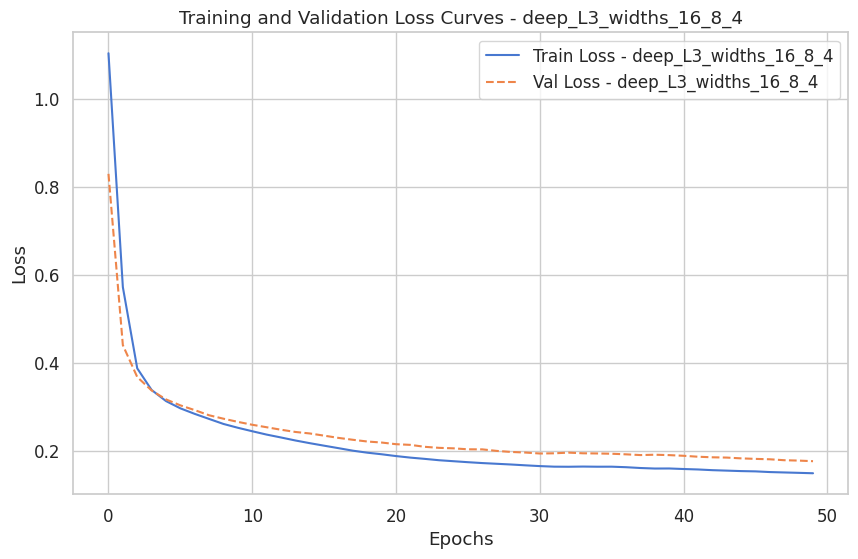

Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory1/results/images/task5_plots/deep_L3_widths_16_8_4_loss_curve.png


<Figure size 640x480 with 0 Axes>

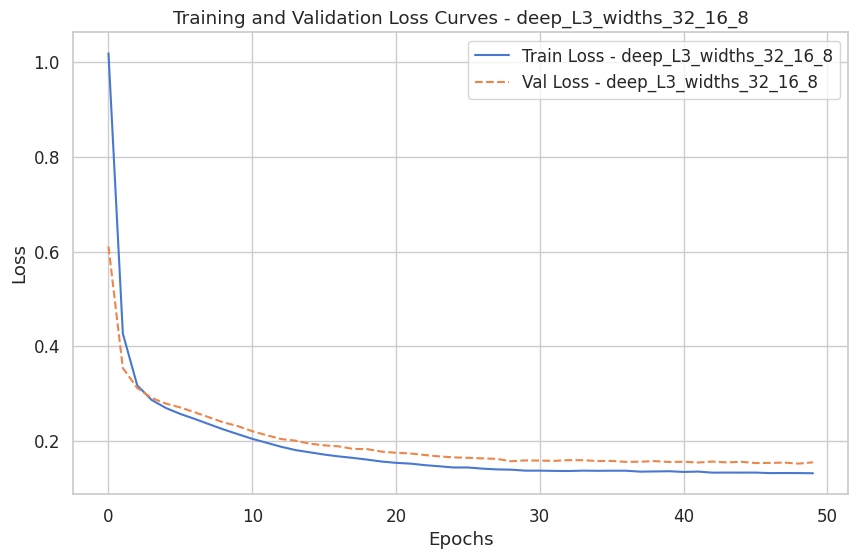

Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory1/results/images/task5_plots/deep_L3_widths_32_16_8_loss_curve.png


<Figure size 640x480 with 0 Axes>

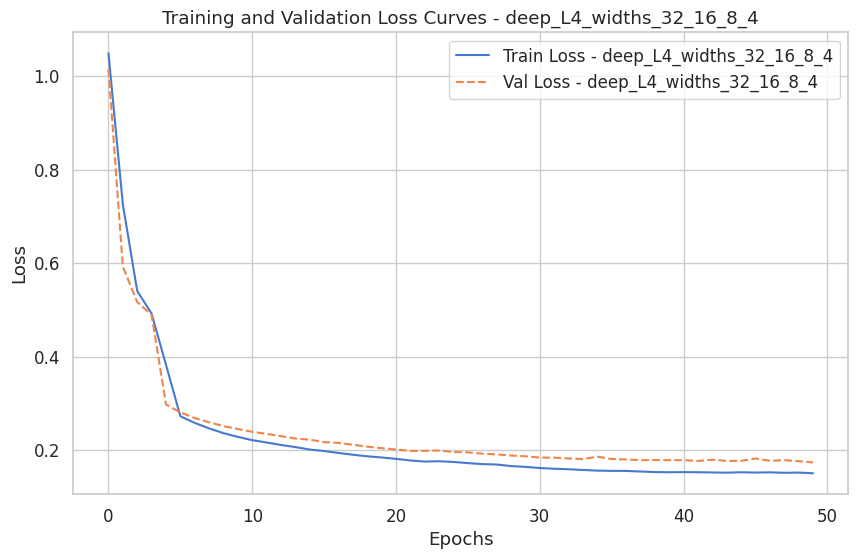

Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory1/results/images/task5_plots/deep_L4_widths_32_16_8_4_loss_curve.png


<Figure size 640x480 with 0 Axes>

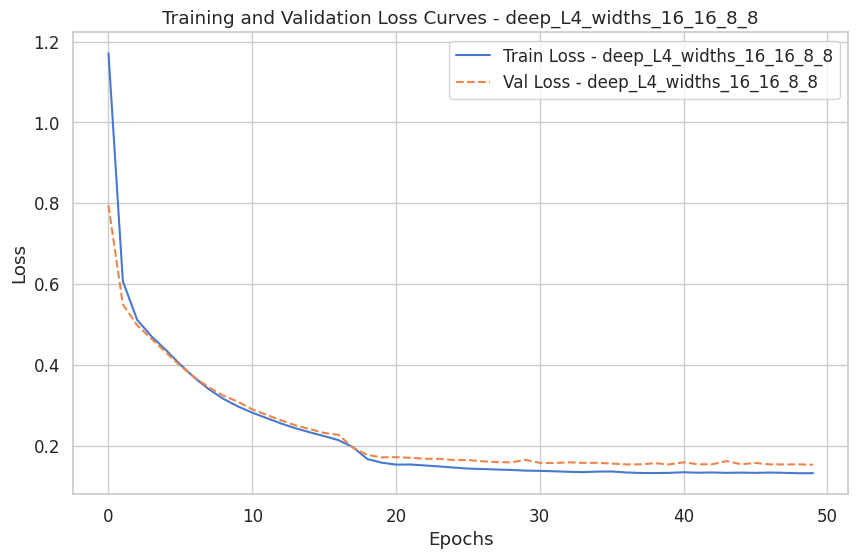

Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory1/results/images/task5_plots/deep_L4_widths_16_16_8_8_loss_curve.png


<Figure size 640x480 with 0 Axes>

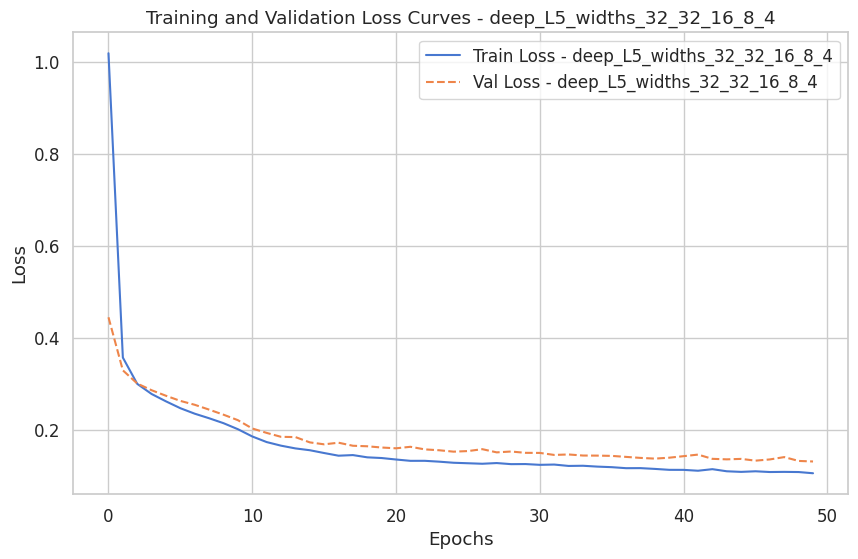

Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory1/results/images/task5_plots/deep_L5_widths_32_32_16_8_4_loss_curve.png


<Figure size 640x480 with 0 Axes>

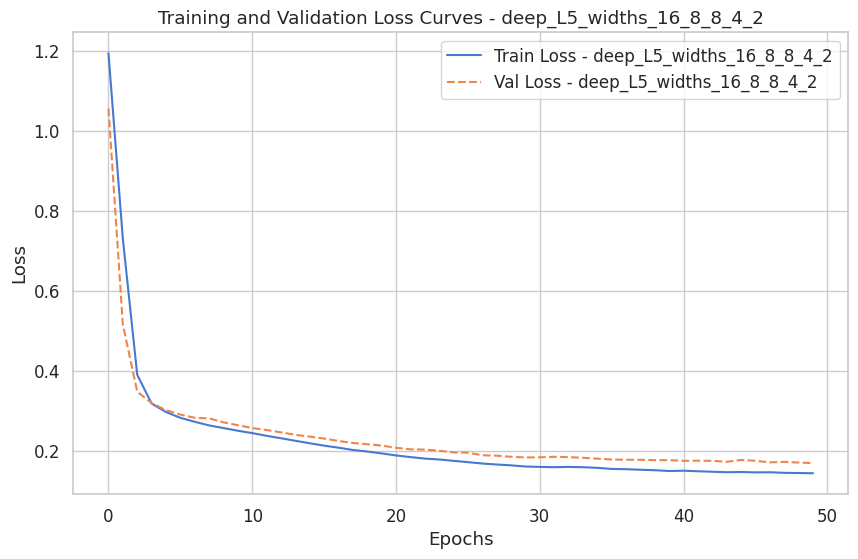

Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory1/results/images/task5_plots/deep_L5_widths_16_8_8_4_2_loss_curve.png


<Figure size 640x480 with 0 Axes>

In [59]:
# --- Train models for different depths and widths ---

input_dim_deep = X_train_std_no_port.shape[1] # Use the data without 'Destination Port'
output_dim_deep = len(np.unique(y_train_no_port))

trained_deep_models = {}
deep_loss_curves = {}

# Define early stopping parameters for deep networks
min_delta_deep = 0.00001
patience_deep = 15 # Adjusted patience for potentially longer training

for L, configs in layer_configs.items():
    for widths in configs:
        tag = f"deep_L{L}_widths_{'_'.join(map(str, widths))}"
        print(f"\nTraining model: {tag} (ReLU activation)...")

        # Set hyperparameters
        model = DeepFFNN(input_dim_deep, widths, output_dim_deep, activation='relu')
        criterion = nn.CrossEntropyLoss() # Start with unweighted loss
        optimizer = optim.AdamW(model.parameters(), lr=0.0005)
        epochs = 50 # As per task

        # Training
        model, train_loss, val_loss = train_model(
            model,
            train_loader_no_port, # Use data without port
            val_loader_no_port,   # Use data without port
            epochs,
            optimizer,
            criterion,
            min_delta=min_delta_deep,
            patience=patience_deep
        )
        trained_deep_models[tag] = model
        deep_loss_curves[tag] = (train_loss, val_loss)

# --- Plot loss curves for all deep models ---

for tag, (train_loss, val_loss) in deep_loss_curves.items():
    plt.figure(figsize=(10,6))
    plt.plot(train_loss, label=f'Train Loss - {tag}')
    plt.plot(val_loss, '--', label=f'Val Loss - {tag}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss Curves - {tag}')
    plt.legend()
    plt.show()

    # Save the plot to the specified path
    save_plot(plt.gcf(), f"{tag}_loss_curve", save_dir) # Use plt.gcf() to get the current figure

### Q: • Plot and analyze the losses. Do the models converge?

TO DO

In [60]:
# --- Evaluate validation set and identify the best architecture ---
# Update the evaluate_model function to optionally return predictions
def evaluate_model(model, X_tensor, y_true, return_preds=False):
    model.eval()
    with torch.no_grad():
        outputs = model(X_tensor)
        y_pred = torch.argmax(outputs, axis=1).numpy()
    if return_preds:
        return y_pred
    else:
        report = classification_report(y_true, y_pred, digits=4)
        return report

deep_validation_results = {}

print("\nValidation classification reports for deep models:")
for tag, model in trained_deep_models.items():
    print(f"\n--- Model {tag} ---")
    # Evaluate on the validation set without the port
    report = evaluate_model(model, X_val_tensor_no_port, y_val_no_port)
    print(report)
    # Store relevant metrics
    deep_validation_results[tag] = classification_report(y_val_no_port, evaluate_model(model, X_val_tensor_no_port, y_val_no_port, return_preds=True), output_dict=True)


# Identify the best model based on a chosen metric (e.g., macro avg F1-score)
best_macro_f1 = -1
best_deep_model_tag = None

for tag, metrics in deep_validation_results.items():
    macro_f1 = metrics['macro avg']['f1-score']
    if macro_f1 > best_macro_f1:
        best_macro_f1 = macro_f1
        best_deep_model_tag = tag

print(f"\nBest performing deep architecture (based on macro avg F1 on validation set): {best_deep_model_tag}")
best_deep_model = trained_deep_models[best_deep_model_tag]

print("\nClassification report for the best deep model on the validation set:")
print(classification_report(y_val_no_port, evaluate_model(best_deep_model, X_val_tensor_no_port, y_val_no_port, return_preds=True), target_names=label_encoder_no_port.classes_, digits=4))


Validation classification reports for deep models:

--- Model deep_L3_widths_16_8_4 ---
              precision    recall  f1-score   support

           0     0.9489    0.9787    0.9636      3378
           1     0.8146    0.9404    0.8730       285
           2     0.9824    0.8643    0.9196       774
           3     0.0000    0.0000    0.0000        57

    accuracy                         0.9441      4494
   macro avg     0.6865    0.6958    0.6890      4494
weighted avg     0.9341    0.9441    0.9380      4494


--- Model deep_L3_widths_32_16_8 ---
              precision    recall  f1-score   support

           0     0.9489    0.9790    0.9637      3378
           1     0.8152    0.9439    0.8748       285
           2     0.9838    0.8630    0.9195       774
           3     0.0000    0.0000    0.0000        57

    accuracy                         0.9444      4494
   macro avg     0.6870    0.6965    0.6895      4494
weighted avg     0.9344    0.9444    0.9382      4494


--

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

### Q: Calculate the performance in the validation set and identify the best-performing architecture. How do you select one?

TO DO

# The impact of Batch Size

### Q: Use the best hyperparameter identified in the previous step and experiment with different batch sizes. In particular, use as batch size: {4, 64, 256, 1024}. Does performance change? And why? Report the validation results.

TO DO

In [61]:
# --- Experiment with different batch sizes ---

# Assuming 'best_deep_model_tag' and 'trained_deep_models' are available from the previous step
best_widths = layer_configs[int(best_deep_model_tag.split('_')[1][1])][int(best_deep_model_tag.split('_')[-1].split('_')[0] == str(layer_configs[int(best_deep_model_tag.split('_')[1][1])][0][0]))]


input_dim_deep = X_train_std_no_port.shape[1]
output_dim_deep = len(np.unique(y_train_no_port))

batch_sizes = [4, 64, 256, 1024]
batch_size_results = {}

print(f"\nExperimenting with different batch sizes for the best architecture ({best_deep_model_tag})...")

for bs in batch_sizes:
    print(f"\nTraining with batch size: {bs}")

    # Create new DataLoaders for the current batch size
    train_loader_bs = DataLoader(TensorDataset(X_train_tensor_no_port, y_train_tensor_no_port), batch_size=bs, shuffle=True)
    val_loader_bs   = DataLoader(TensorDataset(X_val_tensor_no_port, y_val_tensor_no_port), batch_size=bs, shuffle=False)

    # Instantiate a fresh model for each batch size experiment
    model_bs = DeepFFNN(input_dim_deep, best_widths, output_dim_deep, activation='relu')

    # Set hyperparameters (same as best ReLU model from Task 2/Task 5 baseline)
    min_delta = 0.00001
    patience = 15 # Use patience from deep network training
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model_bs.parameters(), lr=0.0005)
    epochs = 50 # Use epochs from deep network training

    start_time = time.time()
    # Training
    model_bs, train_loss_bs, val_loss_bs = train_model(
        model_bs,
        train_loader_bs,
        val_loader_bs,
        epochs,
        optimizer,
        criterion,
        min_delta,
        patience
    )
    end_time = time.time()
    training_time = end_time - start_time

    # Evaluate on validation set
    report_bs = evaluate_model(model_bs, X_val_tensor_no_port, y_val_no_port)
    print(f"\nValidation report for batch size {bs}:")
    print(report_bs)

    batch_size_results[bs] = {
        'training_time': training_time,
        'validation_report': report_bs
    }

# You can further analyze batch_size_results here, e.g., compare metrics across batch sizes


Experimenting with different batch sizes for the best architecture (deep_L5_widths_32_32_16_8_4)...

Training with batch size: 4
Epoch 1/50 - Train Loss: 0.3826, Val Loss: 0.2735
Epoch 5/50 - Train Loss: 0.1575, Val Loss: 0.1827
Epoch 10/50 - Train Loss: 0.1362, Val Loss: 0.1636
Epoch 15/50 - Train Loss: 0.1313, Val Loss: 0.1493
Epoch 20/50 - Train Loss: 0.1294, Val Loss: 0.1488
Epoch 25/50 - Train Loss: 0.1287, Val Loss: 0.1484
Epoch 30/50 - Train Loss: 0.1231, Val Loss: 0.1383
Epoch 35/50 - Train Loss: 0.1196, Val Loss: 0.1394
Epoch 40/50 - Train Loss: 0.1196, Val Loss: 0.1334
Epoch 45/50 - Train Loss: 0.1206, Val Loss: 0.1459
Epoch 50/50 - Train Loss: 0.1195, Val Loss: 0.1456

Validation report for batch size 4:
              precision    recall  f1-score   support

           0     0.9604    0.9754    0.9678      3378
           1     0.8152    0.9439    0.8748       285
           2     0.9734    0.8966    0.9334       774
           3     0.5500    0.1930    0.2857        57

  

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50 - Train Loss: 1.5165, Val Loss: 1.4887
Epoch 5/50 - Train Loss: 0.5660, Val Loss: 0.4893
Epoch 10/50 - Train Loss: 0.2748, Val Loss: 0.2869
Epoch 15/50 - Train Loss: 0.2439, Val Loss: 0.2623
Epoch 20/50 - Train Loss: 0.2224, Val Loss: 0.2436
Epoch 25/50 - Train Loss: 0.1942, Val Loss: 0.2167
Epoch 30/50 - Train Loss: 0.1608, Val Loss: 0.1868
Epoch 35/50 - Train Loss: 0.1462, Val Loss: 0.1739
Epoch 40/50 - Train Loss: 0.1381, Val Loss: 0.1679
Epoch 45/50 - Train Loss: 0.1360, Val Loss: 0.1659
Epoch 50/50 - Train Loss: 0.1352, Val Loss: 0.1679

Validation report for batch size 256:
              precision    recall  f1-score   support

           0     0.9547    0.9784    0.9664      3378
           1     0.8078    0.9439    0.8706       285
           2     0.9857    0.8902    0.9355       774
           3     0.0000    0.0000    0.0000        57

    accuracy                         0.9486      4494
   macro avg     0.6870    0.7031    0.6931      4494
weighted avg     0.938

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50 - Train Loss: 1.6991, Val Loss: 1.6811
Epoch 5/50 - Train Loss: 1.5502, Val Loss: 1.5246
Epoch 10/50 - Train Loss: 1.1198, Val Loss: 1.0403
Epoch 15/50 - Train Loss: 0.6876, Val Loss: 0.6754
Epoch 20/50 - Train Loss: 0.3674, Val Loss: 0.3733
Epoch 25/50 - Train Loss: 0.3292, Val Loss: 0.3380
Epoch 30/50 - Train Loss: 0.3069, Val Loss: 0.3155
Epoch 35/50 - Train Loss: 0.2886, Val Loss: 0.3005
Epoch 40/50 - Train Loss: 0.2766, Val Loss: 0.2915
Epoch 45/50 - Train Loss: 0.2716, Val Loss: 0.2846
Epoch 50/50 - Train Loss: 0.2634, Val Loss: 0.2797

Validation report for batch size 1024:
              precision    recall  f1-score   support

           0     0.8813    0.9976    0.9359      3378
           1     0.0000    0.0000    0.0000       285
           2     0.9866    0.8540    0.9155       774
           3     0.0000    0.0000    0.0000        57

    accuracy                         0.8970      4494
   macro avg     0.4670    0.4629    0.4628      4494
weighted avg     0.83

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Q: How long does it take to train the models depending on the batch size? And why?

TO DO

# The impact of the Optimizer


Experimenting with different optimizers for the best architecture (deep_L5_widths_32_32_16_8_4)...

Training with optimizer: SGD
Epoch 1/50 - Train Loss: 1.5031, Val Loss: 1.4775
Epoch 5/50 - Train Loss: 1.3168, Val Loss: 1.2972
Epoch 10/50 - Train Loss: 1.1379, Val Loss: 1.1246
Epoch 15/50 - Train Loss: 1.0099, Val Loss: 1.0021
Epoch 20/50 - Train Loss: 0.9247, Val Loss: 0.9211
Epoch 25/50 - Train Loss: 0.8711, Val Loss: 0.8710
Epoch 30/50 - Train Loss: 0.8388, Val Loss: 0.8403
Epoch 35/50 - Train Loss: 0.8178, Val Loss: 0.8206
Epoch 40/50 - Train Loss: 0.8040, Val Loss: 0.8073
Epoch 45/50 - Train Loss: 0.7938, Val Loss: 0.7975
Epoch 50/50 - Train Loss: 0.7859, Val Loss: 0.7898

Validation report for optimizer SGD:
              precision    recall  f1-score   support

           0     0.7517    1.0000    0.8582      3378
           1     0.0000    0.0000    0.0000       285
           2     0.0000    0.0000    0.0000       774
           3     0.0000    0.0000    0.0000        57

 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50 - Train Loss: 1.5866, Val Loss: 1.5548
Epoch 5/50 - Train Loss: 1.3689, Val Loss: 1.3464
Epoch 10/50 - Train Loss: 1.1656, Val Loss: 1.1507
Epoch 15/50 - Train Loss: 1.0236, Val Loss: 1.0152
Epoch 20/50 - Train Loss: 0.9317, Val Loss: 0.9284
Epoch 25/50 - Train Loss: 0.8756, Val Loss: 0.8757
Epoch 30/50 - Train Loss: 0.8417, Val Loss: 0.8436
Epoch 35/50 - Train Loss: 0.8194, Val Loss: 0.8227
Epoch 40/50 - Train Loss: 0.8039, Val Loss: 0.8077
Epoch 45/50 - Train Loss: 0.7916, Val Loss: 0.7953
Epoch 50/50 - Train Loss: 0.7797, Val Loss: 0.7840

Validation report for optimizer SGD_momentum_0.1:
              precision    recall  f1-score   support

           0     0.7517    1.0000    0.8582      3378
           1     0.0000    0.0000    0.0000       285
           2     0.0000    0.0000    0.0000       774
           3     0.0000    0.0000    0.0000        57

    accuracy                         0.7517      4494
   macro avg     0.1879    0.2500    0.2146      4494
weighted a

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50 - Train Loss: 1.5516, Val Loss: 1.5044
Epoch 5/50 - Train Loss: 1.2479, Val Loss: 1.2186
Epoch 10/50 - Train Loss: 1.0260, Val Loss: 1.0122
Epoch 15/50 - Train Loss: 0.9121, Val Loss: 0.9069
Epoch 20/50 - Train Loss: 0.8540, Val Loss: 0.8528
Epoch 25/50 - Train Loss: 0.8223, Val Loss: 0.8234
Epoch 30/50 - Train Loss: 0.8036, Val Loss: 0.8062
Epoch 35/50 - Train Loss: 0.7928, Val Loss: 0.7955
Epoch 40/50 - Train Loss: 0.7850, Val Loss: 0.7883
Epoch 45/50 - Train Loss: 0.7796, Val Loss: 0.7831
Epoch 50/50 - Train Loss: 0.7754, Val Loss: 0.7791

Validation report for optimizer SGD_momentum_0.5:
              precision    recall  f1-score   support

           0     0.7517    1.0000    0.8582      3378
           1     0.0000    0.0000    0.0000       285
           2     0.0000    0.0000    0.0000       774
           3     0.0000    0.0000    0.0000        57

    accuracy                         0.7517      4494
   macro avg     0.1879    0.2500    0.2146      4494
weighted a

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50 - Train Loss: 1.2597, Val Loss: 1.0941
Epoch 5/50 - Train Loss: 0.7871, Val Loss: 0.7836
Epoch 10/50 - Train Loss: 0.7519, Val Loss: 0.7542
Epoch 15/50 - Train Loss: 0.7078, Val Loss: 0.7004
Epoch 20/50 - Train Loss: 0.5883, Val Loss: 0.5794
Epoch 25/50 - Train Loss: 0.4167, Val Loss: 0.4144
Epoch 30/50 - Train Loss: 0.3447, Val Loss: 0.3501
Epoch 35/50 - Train Loss: 0.3155, Val Loss: 0.3257
Epoch 40/50 - Train Loss: 0.2958, Val Loss: 0.3117
Epoch 45/50 - Train Loss: 0.2834, Val Loss: 0.3016
Epoch 50/50 - Train Loss: 0.2705, Val Loss: 0.2924

Validation report for optimizer SGD_momentum_0.9:
              precision    recall  f1-score   support

           0     0.8846    0.9962    0.9371      3378
           1     0.6667    0.0561    0.1036       285
           2     0.9910    0.8527    0.9167       774
           3     0.0000    0.0000    0.0000        57

    accuracy                         0.8992      4494
   macro avg     0.6356    0.4763    0.4893      4494
weighted a

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50 - Train Loss: 1.5405, Val Loss: 1.4421
Epoch 5/50 - Train Loss: 0.9617, Val Loss: 0.9232
Epoch 10/50 - Train Loss: 0.6465, Val Loss: 0.6314
Epoch 15/50 - Train Loss: 0.4985, Val Loss: 0.4970
Epoch 20/50 - Train Loss: 0.4351, Val Loss: 0.4410
Epoch 25/50 - Train Loss: 0.4090, Val Loss: 0.4183
Epoch 30/50 - Train Loss: 0.3981, Val Loss: 0.4090
Epoch 35/50 - Train Loss: 0.3939, Val Loss: 0.4066
Epoch 40/50 - Train Loss: 0.3922, Val Loss: 0.4051
Epoch 45/50 - Train Loss: 0.3922, Val Loss: 0.4047
Epoch 50/50 - Train Loss: 0.3922, Val Loss: 0.4046

Validation report for optimizer AdamW:
              precision    recall  f1-score   support

           0     0.8811    1.0000    0.9368      3378
           1     0.0000    0.0000    0.0000       285
           2     0.9985    0.8514    0.9191       774
           3     0.0000    0.0000    0.0000        57

    accuracy                         0.8983      4494
   macro avg     0.4699    0.4629    0.4640      4494
weighted avg     0.83

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


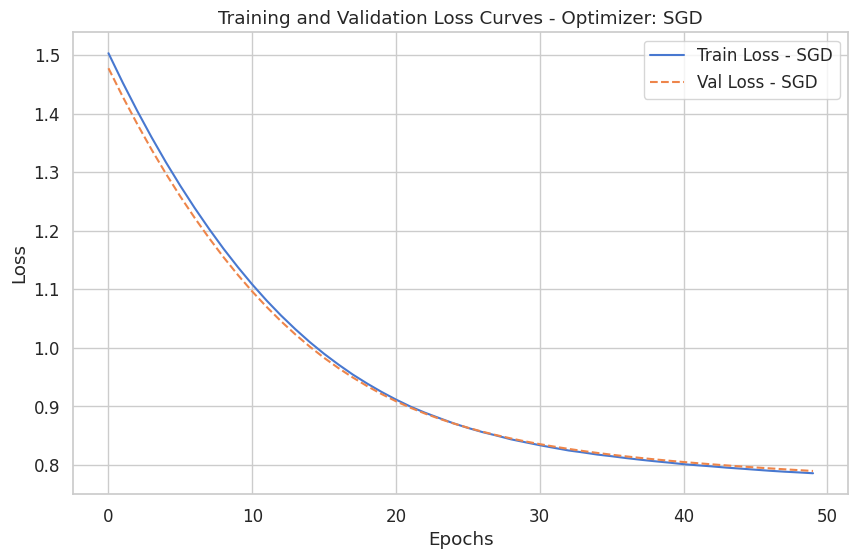

Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory1/results/images/task5_plots/SGD_loss_curve.png


<Figure size 640x480 with 0 Axes>

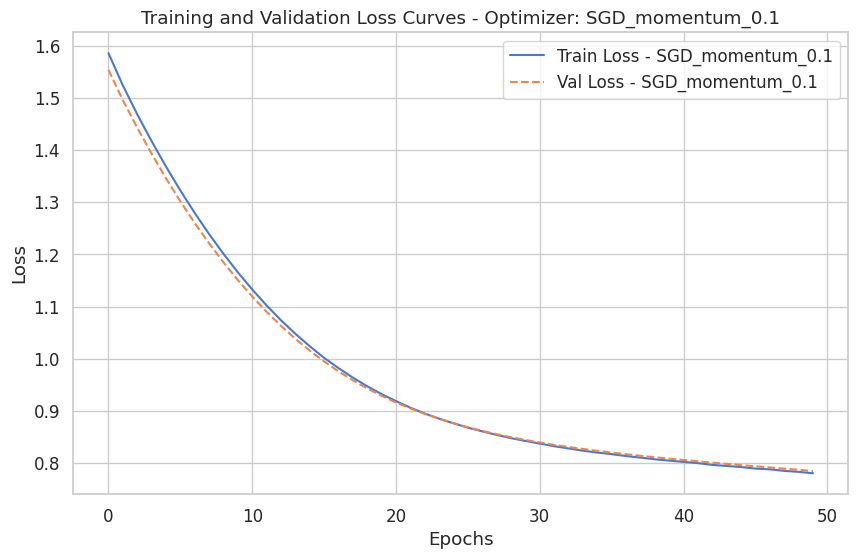

Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory1/results/images/task5_plots/SGD_momentum_0.1_loss_curve.png


<Figure size 640x480 with 0 Axes>

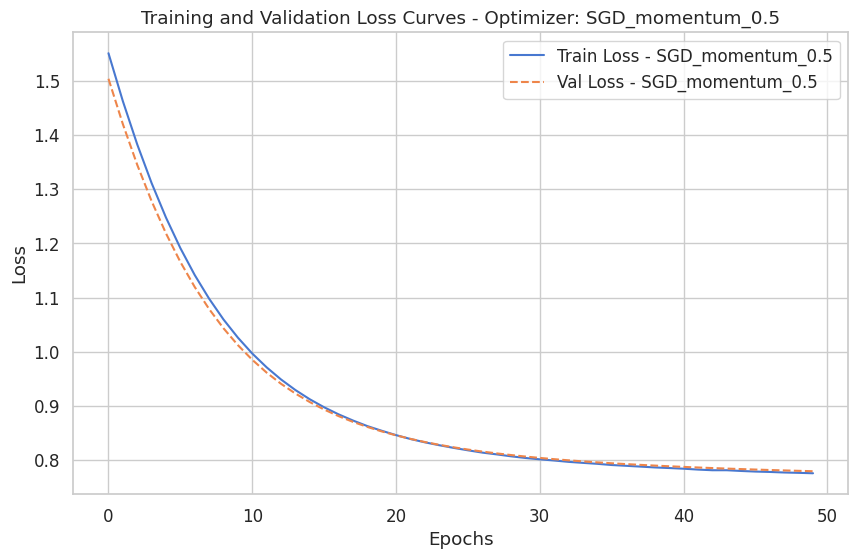

Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory1/results/images/task5_plots/SGD_momentum_0.5_loss_curve.png


<Figure size 640x480 with 0 Axes>

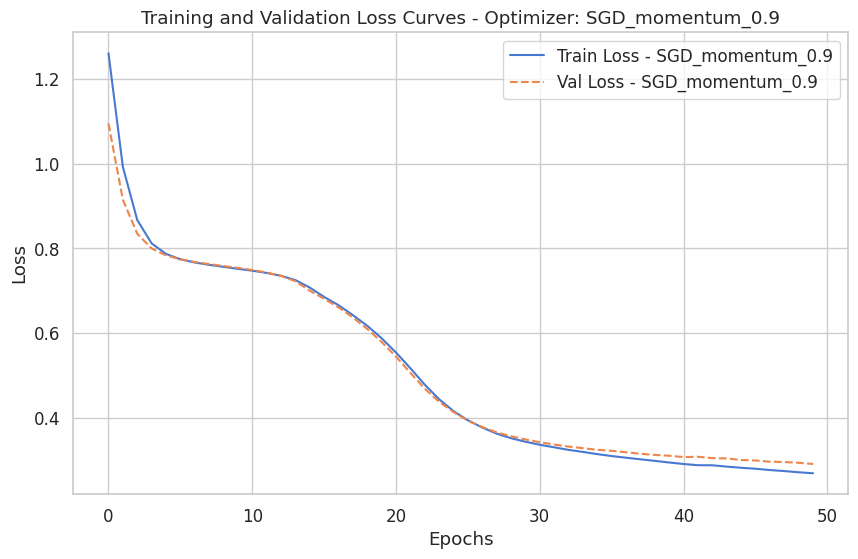

Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory1/results/images/task5_plots/SGD_momentum_0.9_loss_curve.png


<Figure size 640x480 with 0 Axes>

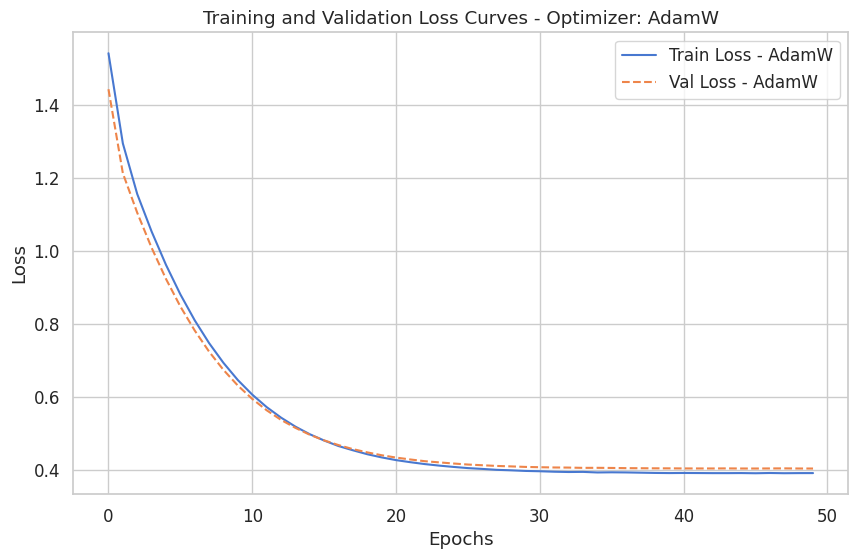

Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory1/results/images/task5_plots/AdamW_loss_curve.png


<Figure size 640x480 with 0 Axes>

In [62]:
# --- Experiment with different optimizers ---

# Assuming 'best_deep_model_tag' and 'best_widths' are available
input_dim_deep = X_train_std_no_port.shape[1]
output_dim_deep = len(np.unique(y_train_no_port))
batch_size_opt = 64 # Use a reasonable batch size, e.g., 64

# Create DataLoaders for optimizer experiments
train_loader_opt = DataLoader(TensorDataset(X_train_tensor_no_port, y_train_tensor_no_port), batch_size=batch_size_opt, shuffle=True)
val_loader_opt   = DataLoader(TensorDataset(X_val_tensor_no_port, y_val_tensor_no_port), batch_size=batch_size_opt, shuffle=False)

optimizers_to_test = {
    'SGD': optim.SGD,
    'SGD_momentum_0.1': lambda params, lr: optim.SGD(params, lr=lr, momentum=0.1),
    'SGD_momentum_0.5': lambda params, lr: optim.SGD(params, lr=lr, momentum=0.5),
    'SGD_momentum_0.9': lambda params, lr: optim.SGD(params, lr=lr, momentum=0.9),
    'AdamW': optim.AdamW
}

optimizer_results = {}
optimizer_loss_curves = {}

print(f"\nExperimenting with different optimizers for the best architecture ({best_deep_model_tag})...")

for opt_name, opt_class in optimizers_to_test.items():
    print(f"\nTraining with optimizer: {opt_name}")

    # Instantiate a fresh model for each optimizer experiment
    model_opt = DeepFFNN(input_dim_deep, best_widths, output_dim_deep, activation='relu')

    # Set hyperparameters (same as best ReLU model from Task 2/Task 5 baseline, but with optimizer variations)
    min_delta = 0.00001
    patience = 15
    criterion = nn.CrossEntropyLoss()
    lr = 0.0005 # Initial learning rate
    epochs = 50 # Use epochs from deep network training

    # Instantiate the optimizer
    if opt_name in ['SGD', 'AdamW']:
         optimizer = opt_class(model_opt.parameters(), lr=lr)
    else:
        optimizer = opt_class(model_opt.parameters(), lr=lr)


    start_time = time.time()
    # Training
    model_opt, train_loss_opt, val_loss_opt = train_model(
        model_opt,
        train_loader_opt,
        val_loader_opt,
        epochs,
        optimizer,
        criterion,
        min_delta,
        patience
    )
    end_time = time.time()
    training_time = end_time - start_time

    # Evaluate on validation set
    report_opt = evaluate_model(model_opt, X_val_tensor_no_port, y_val_no_port)
    print(f"\nValidation report for optimizer {opt_name}:")
    print(report_opt)

    optimizer_results[opt_name] = {
        'training_time': training_time,
        'validation_report': report_opt
    }
    optimizer_loss_curves[opt_name] = (train_loss_opt, val_loss_opt)

# --- Plot loss curves for all optimizer experiments ---

for opt_name, (train_loss, val_loss) in optimizer_loss_curves.items():
    plt.figure(figsize=(10,6))
    plt.plot(train_loss, label=f'Train Loss - {opt_name}')
    plt.plot(val_loss, '--', label=f'Val Loss - {opt_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss Curves - Optimizer: {opt_name}')
    plt.legend()
    plt.show()

    # Save the plot to the specified path
    save_plot(plt.gcf(), f"{opt_name}_loss_curve", save_dir) # Use plt.gcf() to get the current figure

### Q: Finally, evaluate here how the optimizers affect the classification performance, training time and loss trend. The evaluated optimizers are: Stochastic Gradient Descent (SGD), SGD with Momentum(0.1, 0.5, 0.9) and AdamW. Is there a difference in the trend of the loss functions?

TO DO

### Q: How long does it take to train the models with the different optimizers? And why?

TO DO

### Q: Now, focus on the architecture with the best optimizer. Evaluate the effects of the different learning rates and epochs. Report the test results for the best model.

TO DO

In [63]:
# --- Print validation reports for each optimizer experiment ---

print("\nValidation reports for different optimizers:")
for opt_name, results in optimizer_results.items():
    print(f"\n--- Optimizer: {opt_name} ---")
    print(results['validation_report'])


Validation reports for different optimizers:

--- Optimizer: SGD ---
              precision    recall  f1-score   support

           0     0.7517    1.0000    0.8582      3378
           1     0.0000    0.0000    0.0000       285
           2     0.0000    0.0000    0.0000       774
           3     0.0000    0.0000    0.0000        57

    accuracy                         0.7517      4494
   macro avg     0.1879    0.2500    0.2146      4494
weighted avg     0.5650    0.7517    0.6451      4494


--- Optimizer: SGD_momentum_0.1 ---
              precision    recall  f1-score   support

           0     0.7517    1.0000    0.8582      3378
           1     0.0000    0.0000    0.0000       285
           2     0.0000    0.0000    0.0000       774
           3     0.0000    0.0000    0.0000        57

    accuracy                         0.7517      4494
   macro avg     0.1879    0.2500    0.2146      4494
weighted avg     0.5650    0.7517    0.6451      4494


--- Optimizer: SGD_mom

## Task 6 — Overfitting and Regularization
- Build 6-layer FFNN with widths [256, 128, 64, 32, 16] (the final layer is num_classes)
- Train with ReLU, AdamW lr=5e-4, batch=128, epochs=50
- Inspect losses for signs of overfitting
- Add Dropout and BatchNorm variants; try weight decay (AdamW) and compare validation/test

In [64]:
# Create directory for plots
save_dir = results_path + 'images/' + 'task6_plots/'
os.makedirs(save_dir, exist_ok=True)

In [65]:
# --- Define 6-layer FFNN with Regularization Options ---

class RegularizedDeepFFNN(nn.Module):
    def __init__(self, input_dim, layer_widths, output_dim, activation='relu', dropout_prob=0.0, use_batchnorm=False):
        super(RegularizedDeepFFNN, self).__init__()
        layers = []
        prev_width = input_dim
        for i, width in enumerate(layer_widths):
            layers.append(nn.Linear(prev_width, width))
            if use_batchnorm:
                layers.append(nn.BatchNorm1d(width))
            if activation == 'relu':
                layers.append(nn.ReLU())
            if dropout_prob > 0 and i < len(layer_widths) - 1: # Apply dropout to hidden layers
                layers.append(nn.Dropout(dropout_prob))
            prev_width = width
        layers.append(nn.Linear(prev_width, output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# --- Experiment with Regularization ---

input_dim_reg = X_train_std_no_port.shape[1]
output_dim_reg = len(np.unique(y_train_no_port))
layer_widths_reg = [256, 128, 64, 32, 16] # Same widths as the baseline 6-layer model

# Define hyperparameters for regularization experiments
base_lr = 0.0005
epochs_reg = 50
batch_size_reg = 128
min_delta_reg = 0.00001
patience_reg = 10

regularization_configs = {
    'Baseline': {'dropout_prob': 0.0, 'use_batchnorm': False, 'weight_decay': 0.0},
    'Dropout_0.5': {'dropout_prob': 0.5, 'use_batchnorm': False, 'weight_decay': 0.0},
    'BatchNorm': {'use_batchnorm': True, 'dropout_prob': 0.0, 'weight_decay': 0.0}, # Often combine BN and Dropout, but testing separately first
    'BatchNorm_Dropout_0.5': {'use_batchnorm': True, 'dropout_prob': 0.5, 'weight_decay': 0.0},
    'WeightDecay_1e-4': {'dropout_prob': 0.0, 'use_batchnorm': False, 'weight_decay': 1e-4},
    'WeightDecay_1e-4_BN_Dropout_0.5': {'use_batchnorm': True, 'dropout_prob': 0.5, 'weight_decay': 1e-4}
}

regularized_models = {}
regularized_loss_curves = {}
regularized_validation_reports = {}
regularized_test_reports = {}

for config_name, params in regularization_configs.items():
    print(f"\nTraining model with {config_name}...")

    # Instantiate model with regularization
    model_reg = RegularizedDeepFFNN(
        input_dim_reg,
        layer_widths_reg,
        output_dim_reg,
        activation='relu',
        dropout_prob=params.get('dropout_prob', 0.0),
        use_batchnorm=params.get('use_batchnorm', False)
    )

    # Define optimizer with weight decay
    optimizer_reg = optim.AdamW(model_reg.parameters(), lr=base_lr, weight_decay=params.get('weight_decay', 0.0))
    criterion = nn.CrossEntropyLoss()

    # Create DataLoaders (using the same as the baseline 6-layer model)
    train_loader_reg = train_loader_6layer
    val_loader_reg = val_loader_6layer

    # Training
    model_reg, train_loss_reg, val_loss_reg = train_model(
        model_reg,
        train_loader_reg,
        val_loader_reg,
        epochs_reg,
        optimizer_reg,
        criterion,
        min_delta=min_delta_reg,
        patience=patience_reg
    )

    regularized_models[config_name] = model_reg
    regularized_loss_curves[config_name] = (train_loss_reg, val_loss_reg)

    # Evaluate on validation set
    report_val_reg = evaluate_model(model_reg, X_val_tensor_no_port, y_val_no_port)
    regularized_validation_reports[config_name] = report_val_reg
    print(f"\nValidation report for {config_name}:")
    print(report_val_reg)

    # Evaluate on test set
    report_test_reg = evaluate_model(model_reg, X_test_tensor_no_port, y_test_no_port)
    regularized_test_reports[config_name] = report_test_reg
    print(f"\nTest report for {config_name}:")
    print(report_test_reg)

# --- Plot loss curves for all regularized models ---

for config_name, (train_loss, val_loss) in regularized_loss_curves.items():
    plt.figure(figsize=(10,6))
    plt.plot(train_loss, label=f'Train Loss - {config_name}')
    plt.plot(val_loss, '--', label=f'Val Loss - {config_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Loss Curves - {config_name}')
    plt.legend()
    plt.show()

    # Save the plot to the specified path
    save_plot(plt.gcf(), f"{config_name}_loss_curve", save_dir) # Use plt.gcf() to get the current figure

# You can now compare the reports in regularized_validation_reports and regularized_test_reports


Training model with Baseline...


NameError: name 'train_loader_6layer' is not defined

### Q: Each Neurons per Layer describes how many neurons must be present in each layer. For example: 1st layer 256, 2nd layer 128 etc. What do the losses look like? Is the model overfitting?

TO DO


### Q: Now apply normalization techniques (dropout, batch normalization) and play with the regularization of the weights (AdamW's weight decay). What impact do the different normalization techniques have on validation and testing performance?

TO DO